In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from gensim.models import Phrases

import itertools

import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

import random
from scipy import stats

# A) An overview of the dataset

## 1. Import the data as a pandas DataFrame into your notebook.

In [2]:
df = pd.read_pickle('data_385k.pkl', compression='zip')

## 2. Check the number of rows and columns.  
You should have 385’384 samples and 99 columns.

In [3]:
df.shape

(385384, 99)

## 3. Display a few entries from the DataFrame.

In [4]:
df.head()

alcohol_by_volume        barcode  calcium_per_hundred calcium_unit  \
0                0.0  8001772000030                  NaN          NaN   
1                0.0  7610809001066                  NaN          NaN   
2                0.0  8002530159021                  NaN          NaN   
3                0.0  3033715065788                  NaN          NaN   
4                0.0  7610848492740                  NaN          NaN   

   carbohydrates_per_hundred  carbohydrates_per_portion carbohydrates_unit  \
0                      75.00                      37.50                  g   
1                       1.50                       1.13                  g   
2                      52.68                        NaN                  g   
3                      70.40                      11.97                  g   
4                      37.00                       7.40                  g   

   cholesterol_per_hundred cholesterol_unit  copper_cu_per_hundred  ...  \
0                      NaN              NaN                    NaN  ...   
1                      NaN              NaN                    NaN  ...   
2                      NaN              NaN                    NaN  ...   
3                      NaN              NaN                    NaN  ...   
4                      NaN              NaN                    NaN  ...   

  vitamin_b5_panthothenic_acid_per_hundred vitamin_b5_panthothenic_acid_unit  \
0                                      NaN                               NaN   
1                                      NaN                               NaN   
2                                      NaN                               NaN   
3                                      NaN                               NaN   
4                                      NaN                               NaN   

  vitamin_b6_pyridoxin_per_hundred  vitamin_b6_pyridoxin_unit  \
0                              NaN                        NaN   
1                              NaN                        NaN   
2                              NaN                        NaN   
3                              NaN                        NaN   
4                              NaN                        NaN   

   vitamin_c_ascorbic_acid_per_hundred vitamin_c_ascorbic_acid_unit  \
0                                  NaN                          NaN   
1                                  NaN                          NaN   
2                                  NaN                          NaN   
3                                  NaN                          NaN   
4                                  NaN                          NaN   

   vitamin_d_d2_d3_international_units_per_hundred  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

   vitamin_d_d2_d3_international_units_unit zinc_per_hundred  zinc_unit  
0                                       NaN              NaN        NaN  
1                                       NaN              NaN        NaN  
2                                       NaN              NaN        NaN  
3                                       NaN              NaN        NaN  
4                                       NaN              NaN        NaN  

[5 rows x 99 columns]

## 4. Check the data type for each column.  
Create separate lists to hold the names of columns of the same data type.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385384 entries, 0 to 385383
Data columns (total 99 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   alcohol_by_volume                                385384 non-null  float64
 1   barcode                                          385384 non-null  object 
 2   calcium_per_hundred                              264979 non-null  float64
 3   calcium_unit                                     265086 non-null  object 
 4   carbohydrates_per_hundred                        351551 non-null  float64
 5   carbohydrates_per_portion                        11480 non-null   float64
 6   carbohydrates_unit                               351828 non-null  object 
 7   cholesterol_per_hundred                          270282 non-null  float64
 8   cholesterol_unit                                 270329 non-null  object 
 9   copper_cu_per_h

In [6]:
### Create lists of column names based on their data type.
float_columns = [x for x in df.columns if df[x].dtypes == 'float64']
int_columns = [x for x in df.columns if df[x].dtypes == 'int64']
object_columns = [x for x in df.columns if df[x].dtypes == 'object']

## 5. Check the data by the type of information they hold. 
Create 3 lists that hold the columns ending in `_per_hundred`, `_per_portion` and `_unit`, respectively. Put the remaining column names in a 4th list named other_cols. Note that you should create these 4 lists without manually selecting the column names.

In [7]:
### Create 4 empty lists
columns_per_hundred = []
columns_per_portion = []
columns_unit = []
columns_other = []

### Append the column names to the lists based on their information
for l in df.columns:
    
    if l.endswith(('_per_hundred')):
        columns_per_hundred.append(l)
        
    elif l.endswith(('_per_portion')):
        columns_per_portion.append(l)
        
    elif l.endswith(('_unit')):
        columns_unit.append(l)
        
    else:
        columns_other.append(l)

# B) Data Cleaning

## 1. Check for duplicates  
Are there any duplicated products in the data? Can you remove them? What is the shape of the remaining data?

In [8]:
### Check for the total number of duplicates
df.duplicated().sum()

10500

In [9]:
print(f'The {round(100*df.duplicated().sum()/df.shape[0], 1)}% of the data are duplicated')

The 2.7% of the data are duplicated


In [10]:
### Let's remove all the duplicated values by keeping the first one
df = df.drop_duplicates(keep='first')
df = df.reset_index(drop=True)

In [11]:
### Check the new shape of the dataframe
df.shape

(374884, 99)

## 2. Check for missing values
This data set contains a lot of missing values. Let’s find out where they are.

### a) Create a table of missing values  
Create a table that shows both the number and the percentage of missing values for all columns sorted from largest to smallest. Make sure all the column names are visible.

In [12]:
pd.set_option('display.max_rows', None)     ### Display all the rows in the pandas dataframe
pd.set_option('display.max_columns', None)  ### Display all the columns in the pandas dataframe

### Create a pandas dataframe with the number and the percentage of missing values for each columns
df_missing = pd.DataFrame([df.isna().sum(), 100*df.isna().sum()/df.shape[0]], index=['number_of_nan', 'percentage_of_nan']).T
df_missing

number_of_nan  \
alcohol_by_volume                                          0.0   
barcode                                                    0.0   
calcium_per_hundred                                   110030.0   
calcium_unit                                          109923.0   
carbohydrates_per_hundred                              26333.0   
carbohydrates_per_portion                             364529.0   
carbohydrates_unit                                     26056.0   
cholesterol_per_hundred                               104602.0   
cholesterol_unit                                      104555.0   
copper_cu_per_hundred                                 371273.0   
copper_cu_unit                                        371273.0   
country                                                    0.0   
created_at                                                 0.0   
energy_kcal_per_hundred                                36310.0   
energy_kcal_per_portion                               364917.0   
energy_kcal_unit                                       37344.0   
energy_per_hundred                                     36313.0   
energy_per_portion                                    365089.0   
energy_unit                                            36125.0   
fat_per_hundred                                        29624.0   
fat_per_portion                                       364478.0   
fat_unit                                               29292.0   
fatty_acids_total_saturated_per_hundred                95733.0   
fatty_acids_total_saturated_unit                       95733.0   
fatty_acids_total_trans_per_hundred                   105277.0   
fatty_acids_total_trans_unit                          105277.0   
fiber_insoluble_per_hundred                           371375.0   
fiber_insoluble_unit                                  371374.0   
fiber_per_hundred                                      90405.0   
fiber_per_portion                                     366707.0   
fiber_soluble_per_hundred                             371057.0   
fiber_soluble_unit                                    371055.0   
fiber_unit                                             90207.0   
folate_total_per_hundred                              367188.0   
folate_total_unit                                     367188.0   
folic_acid_per_hundred                                370428.0   
folic_acid_unit                                       370409.0   
hundred_unit                                               0.0   
id                                                         0.0   
ingredients_en                                         38958.0   
iron_per_hundred                                      110495.0   
iron_unit                                             110418.0   
magnesium_per_hundred                                 363879.0   
magnesium_unit                                        363827.0   
manganese_mn_per_hundred                              371350.0   
manganese_mn_unit                                     371347.0   
monounsaturated_fatty_acids_per_hundred               329810.0   
monounsaturated_fatty_acids_unit                      329789.0   
phosphorus_per_hundred                                363537.0   
phosphorus_unit                                       363532.0   
polyunsaturated_fatty_acids_per_hundred               330164.0   
polyunsaturated_fatty_acids_unit                      330146.0   
portion_quantity                                           0.0   
portion_unit                                               0.0   
potassium_k_per_hundred                               275440.0   
potassium_k_unit                                      275410.0   
product_name_de                                       355736.0   
product_name_en                                        33165.0   
product_name_fr                                       353199.0   
protein_per_hundred                                    24395.0   
protein_per_portion    

### b) Use missingno to visualization  
In the subject on “Advanced data analysis” we will introduce the missingno library. But you can already install it and try it out if you want. Use missingno to help you visualize where the missing are in the whole data frame and when missing values overlap between columns or not.

<Axes: >

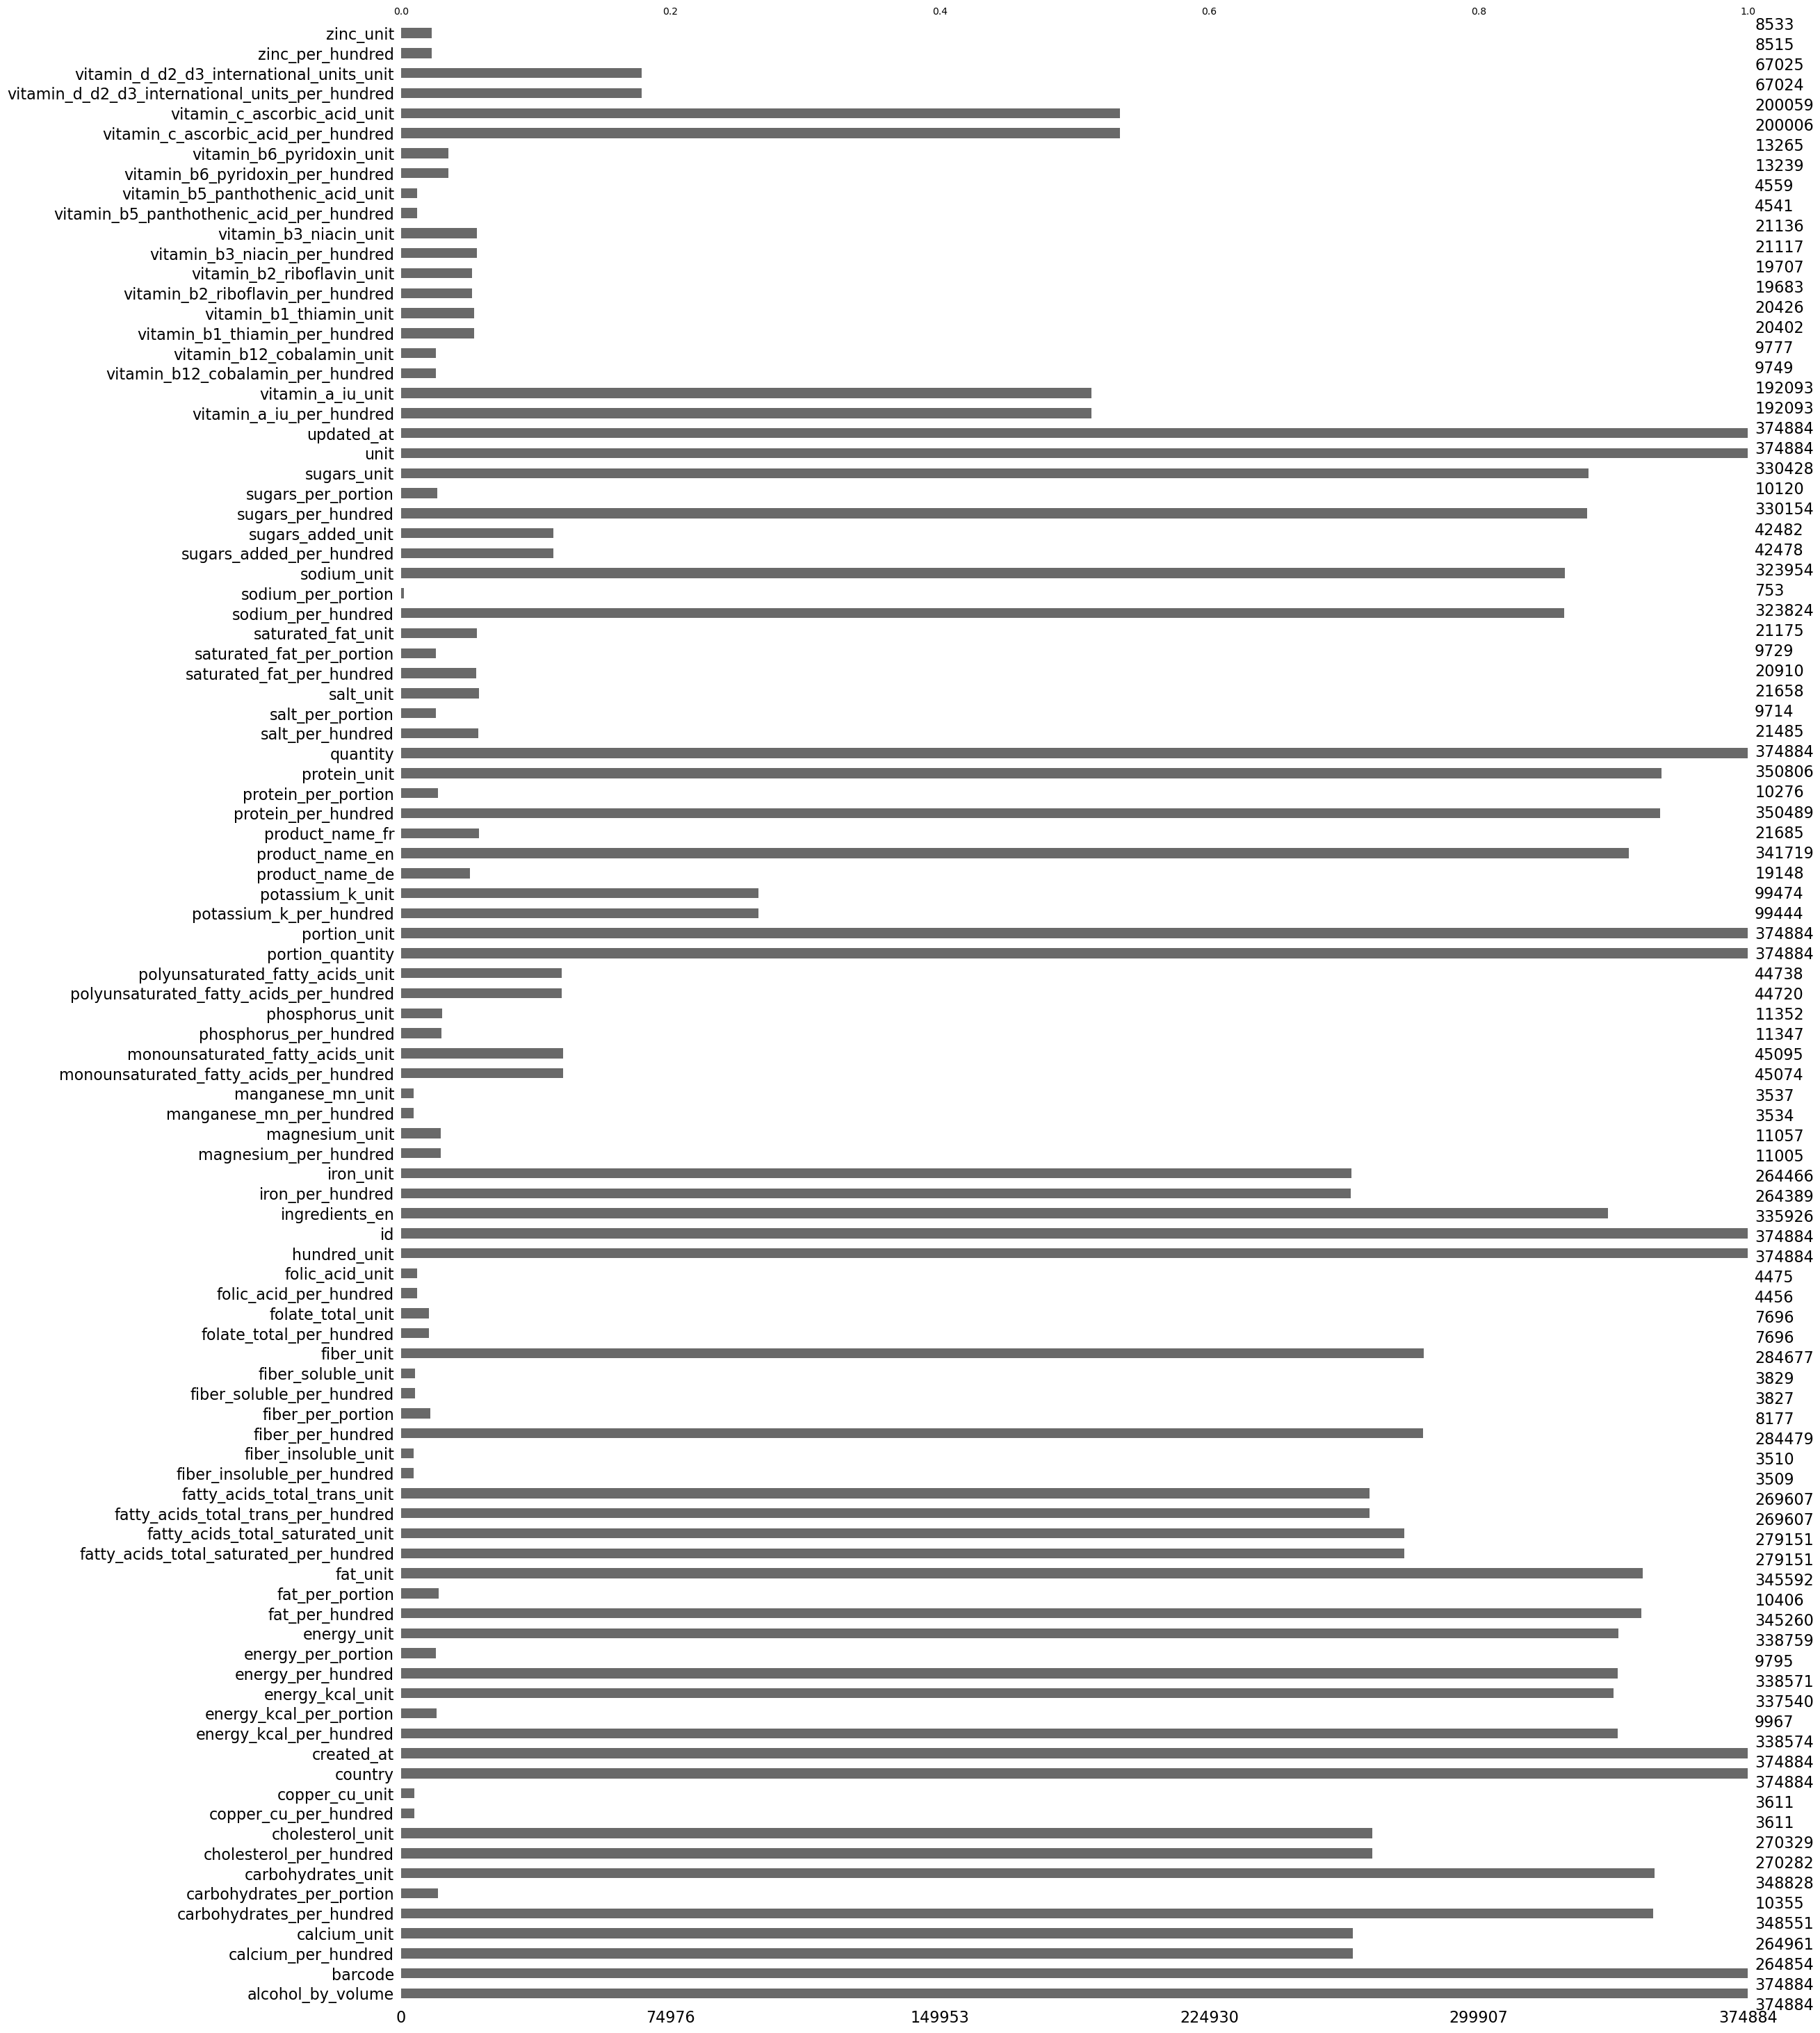

In [13]:
import missingno
missingno.bar(df)

### c) Visualize the percentage of missing values  
In task A5 we created 4 lists for the _per_hundred, _per_portion and _unit columns, and the remaining columns. Use these 4 lists to create 4 line plots or bar charts that show the percentages of missing values in each list. (In addition, you can also use missingno on these 4 reduced data frames)

Text(0.5, 0, 'NaN in %')

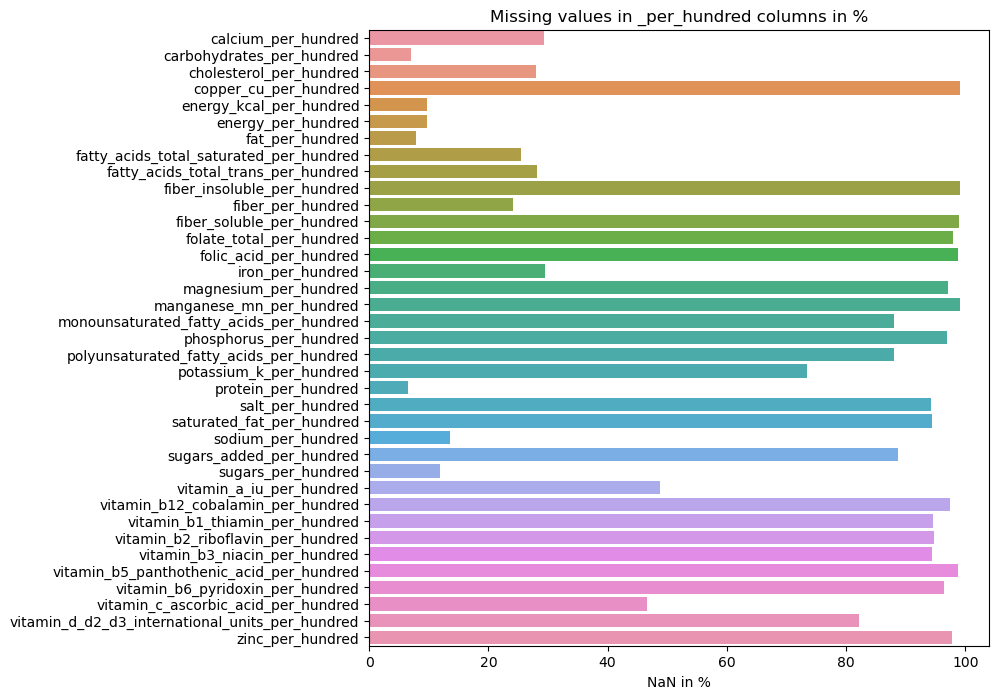

In [14]:
plt.figure(figsize=(8,8))
plt.title('Missing values in _per_hundred columns in %')
sns.barplot(x=df_missing.loc[columns_per_hundred].percentage_of_nan, y=df_missing.loc[columns_per_hundred].index)
plt.xlabel('NaN in %')

Text(0.5, 0, 'NaN in %')

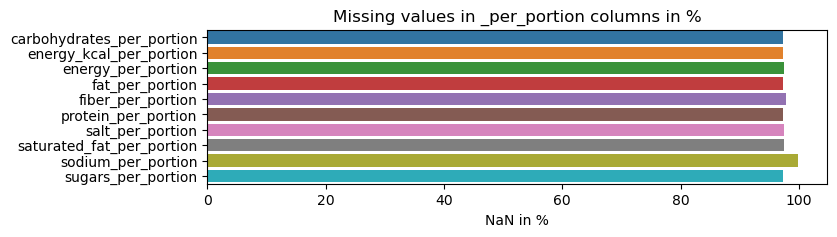

In [15]:
plt.figure(figsize=(8,2))
plt.title('Missing values in _per_portion columns in %')
sns.barplot(x=df_missing.loc[columns_per_portion].percentage_of_nan, y=df_missing.loc[columns_per_portion].index)
plt.xlabel('NaN in %')

Text(0.5, 0, 'NaN in %')

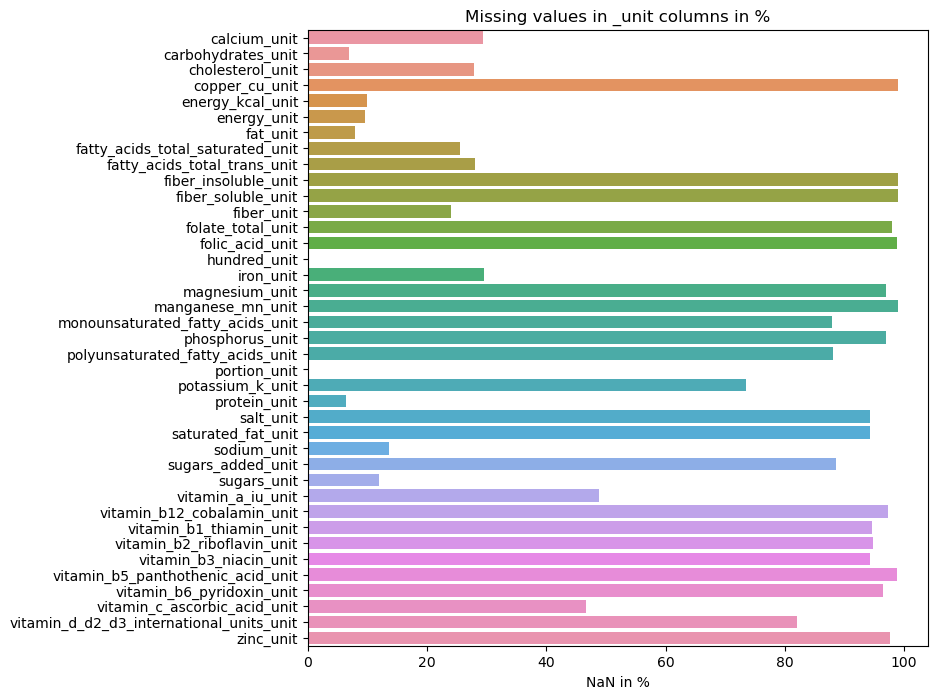

In [16]:
plt.figure(figsize=(8,8))
plt.title('Missing values in _unit columns in %')
sns.barplot(x=df_missing.loc[columns_unit].percentage_of_nan, y=df_missing.loc[columns_unit].index)
plt.xlabel('NaN in %')

Text(0.5, 0, 'NaN in %')

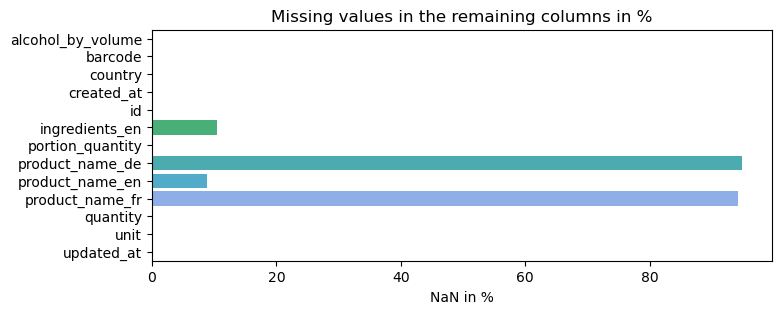

In [17]:
plt.figure(figsize=(8,3))
plt.title('Missing values in the remaining columns in %')
sns.barplot(x=df_missing.loc[columns_other].percentage_of_nan, y=df_missing.loc[columns_other].index)
plt.xlabel('NaN in %')

## 3. Dealing with missing values
Now that you know the extent of missing values in the data, it is time to address them. Your goal is to keep as much data as possible in your data frame. At each step report how many samples and features remain.

In [18]:
### Print the starting shape of the dataframe
df.shape

(374884, 99)

### a) Remove empty rows and columns  
As a first step, remove rows and columns that are completely empty (if there is any).

In [19]:
### Remove empty columns
df = df.loc[:, ~df.apply(lambda x: x.empty, axis=0)]
### Remove empty rows
df = df[~df.apply(lambda x: x.empty, axis=1)]

In [20]:
df.shape

(374884, 99)

There are no fully empty rows or columns

### b) Fill missing values in  `_unit` columns
Start with your list of `_unit` columns, and check some of them and show what information they hold. One simple approach to fill up missing values in categorical columns is to use the most frequent value as a proxy for the missing value. Apply this approach to the `_unit` columns.

In [21]:
### Check the info of the _unit columns
df[columns_unit].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374884 entries, 0 to 374883
Data columns (total 39 columns):
 #   Column                                    Non-Null Count   Dtype 
---  ------                                    --------------   ----- 
 0   calcium_unit                              264961 non-null  object
 1   carbohydrates_unit                        348828 non-null  object
 2   cholesterol_unit                          270329 non-null  object
 3   copper_cu_unit                            3611 non-null    object
 4   energy_kcal_unit                          337540 non-null  object
 5   energy_unit                               338759 non-null  object
 6   fat_unit                                  345592 non-null  object
 7   fatty_acids_total_saturated_unit          279151 non-null  object
 8   fatty_acids_total_trans_unit              269607 non-null  object
 9   fiber_insoluble_unit                      3510 non-null    object
 10  fiber_soluble_unit              

In [22]:
df[columns_unit].head()

calcium_unit carbohydrates_unit cholesterol_unit copper_cu_unit  \
0          NaN                  g              NaN            NaN   
1          NaN                  g              NaN            NaN   
2          NaN                  g              NaN            NaN   
3          NaN                  g              NaN            NaN   
4          NaN                  g              NaN            NaN   

  energy_kcal_unit energy_unit fat_unit fatty_acids_total_saturated_unit  \
0             kCal          kJ        g                              NaN   
1             kCal          kJ        g                              NaN   
2             kCal          kJ        g                              NaN   
3             kCal          kJ        g                              NaN   
4             kCal          kJ        g                              NaN   

  fatty_acids_total_trans_unit fiber_insoluble_unit fiber_soluble_unit  \
0                          NaN                  NaN                NaN   
1                          NaN                  NaN                NaN   
2                          NaN                  NaN                NaN   
3                          NaN                  NaN                NaN   
4                          NaN                  NaN                NaN   

  fiber_unit folate_total_unit folic_acid_unit hundred_unit iron_unit  \
0        NaN               NaN             NaN            g       NaN   
1          g               NaN             NaN            g       NaN   
2        NaN               NaN             NaN            g       NaN   
3          g               NaN             NaN            g       NaN   
4          g               NaN             NaN            g       NaN   

  magnesium_unit manganese_mn_unit monounsaturated_fatty_acids_unit  \
0            NaN               NaN                              NaN   
1            NaN               NaN                              NaN   
2            NaN               NaN                              NaN   
3            NaN               NaN                              NaN   
4            NaN               NaN                              NaN   

  phosphorus_unit polyunsaturated_fatty_acids_unit portion_unit  \
0             NaN                              NaN            g   
1             NaN                              NaN            g   
2             NaN                              NaN            g   
3             NaN                              NaN            g   
4             NaN                              NaN            g   

  potassium_k_unit protein_unit salt_unit saturated_fat_unit sodium_unit  \
0              NaN            g       NaN                NaN         NaN   
1              NaN            g         g                  g         NaN   
2              NaN            g         g                  g         NaN   
3              NaN            g       NaN                  g         NaN   
4              NaN            g         g                  g         NaN   

  sugars_added_unit sugars_unit vitamin_a_iu_unit vitamin_b12_cobalamin_unit  \
0               NaN         NaN               NaN                        NaN   
1               NaN           g               NaN                        NaN   
2               NaN           g               NaN                        NaN   
3               NaN           g               NaN                        NaN   
4               NaN           g               NaN                        NaN   

  vitamin_b1_thiamin_unit vitamin_b2_riboflavin_unit vitamin_b3_niacin_unit  \
0                     NaN                        NaN                    NaN   
1                     NaN                        NaN                    NaN   
2                     NaN                        NaN                    NaN   
3                     NaN                        NaN                    NaN   
4                     NaN                        NaN                    NaN   

  v

In [23]:
### Replace the missing values with the most frequent value
df[columns_unit] = df[columns_unit].apply(lambda x: x.fillna(x.mode().values[0]))

In [24]:
df[columns_unit].head()

calcium_unit carbohydrates_unit cholesterol_unit copper_cu_unit  \
0           mg                  g               mg             mg   
1           mg                  g               mg             mg   
2           mg                  g               mg             mg   
3           mg                  g               mg             mg   
4           mg                  g               mg             mg   

  energy_kcal_unit energy_unit fat_unit fatty_acids_total_saturated_unit  \
0             kCal          kJ        g                                g   
1             kCal          kJ        g                                g   
2             kCal          kJ        g                                g   
3             kCal          kJ        g                                g   
4             kCal          kJ        g                                g   

  fatty_acids_total_trans_unit fiber_insoluble_unit fiber_soluble_unit  \
0                            g                    g                  g   
1                            g                    g                  g   
2                            g                    g                  g   
3                            g                    g                  g   
4                            g                    g                  g   

  fiber_unit folate_total_unit folic_acid_unit hundred_unit iron_unit  \
0          g                µg              µg            g        mg   
1          g                µg              µg            g        mg   
2          g                µg              µg            g        mg   
3          g                µg              µg            g        mg   
4          g                µg              µg            g        mg   

  magnesium_unit manganese_mn_unit monounsaturated_fatty_acids_unit  \
0             mg                mg                                g   
1             mg                mg                                g   
2             mg                mg                                g   
3             mg                mg                                g   
4             mg                mg                                g   

  phosphorus_unit polyunsaturated_fatty_acids_unit portion_unit  \
0              mg                                g            g   
1              mg                                g            g   
2              mg                                g            g   
3              mg                                g            g   
4              mg                                g            g   

  potassium_k_unit protein_unit salt_unit saturated_fat_unit sodium_unit  \
0               mg            g         g                  g           g   
1               mg            g         g                  g           g   
2               mg            g         g                  g           g   
3               mg            g         g                  g           g   
4               mg            g         g                  g           g   

  sugars_added_unit sugars_unit vitamin_a_iu_unit vitamin_b12_cobalamin_unit  \
0                 g           g                IU                         µg   
1                 g           g                IU                         µg   
2                 g           g                IU                         µg   
3                 g           g                IU                         µg   
4                 g           g                IU                         µg   

  vitamin_b1_thiamin_unit vitamin_b2_riboflavin_unit vitamin_b3_niacin_unit  \
0                      mg                         mg                     mg   
1                      mg                         mg                     mg   
2                      mg                         mg                     mg   
3                      mg                         mg                     mg   
4                      mg                         mg                     mg   

  v

In [25]:
### Alternative method to fill missing values in catergorical variables 
# from sklearn.impute import SimpleImputer
# categorical_imputer = SimpleImputer(strategy='most_frequent')
# df[columns_unit] = pd.DataFrame(categorical_imputer.fit_transform(df[columns_unit]), columns=columns_unit).head()

In [26]:
### Check the number of missing values
df[columns_unit].isna().sum().sum()

0

In [27]:
df.shape

(374884, 99)

### c) Fill missing values in `product_name_en` column  
As a second strategy, let’s fill up the missing values of a column using other columns that hold similar information. Apply this approach to the `product_name_en` column. Find columns that hold similar information and use them to replace the missing value in `product_name_en`. Report the number of rows that you managed to fill up.

I can use the `product_name_de` and `product_name_fr` columns to replace missing values in `product_name_en`. We combine these three columns to create the `product_name` column, giving priority to the names in English, then to those in French and, finally, to those in German

In [28]:
### Check for missing values
df.product_name_en.isna().sum()

33165

In [29]:
### Create the product_name column starting from product_name_en
df['product_name'] = df['product_name_en']
### Fill product_name missing values with their respective ones in product_name_fr
df['product_name'] = df['product_name'].fillna(df['product_name_fr'])
### Fill product_name missing values with their respective ones in product_name_de
df['product_name'] = df['product_name'].fillna(df['product_name_de'])

In [30]:
df.product_name.isna().sum()

18866

In [31]:
print(f'{df.product_name_en.isna().sum() - df.product_name.isna().sum()} rows have been filled')

14299 rows have been filled


### d) Fill missing values in `iron_per_hundred` column  
As a third strategy, let’s fill up missing values based on common knowledge. Take the column named `iron_per_hundred` which has about 30% missing values. One possible explanation for its missing values could be that those products are iron-free (like ice cream). Based on this assumption address the missing values for iron_per_hundred.

In [32]:
### Check the percentage of missing values
df.iron_per_hundred.isna().sum()/df.shape[0]

0.29474450763436155

Assuming that the missing values are iron-free, let's fill the nan with 0

In [33]:
df['iron_per_hundred'] = df['iron_per_hundred'].fillna(0)

### e) Fill missing values in `ingredients_en` column  
Another strategy for text-based columns is to indicate that some of the fields are missing. For instance, the column `ingredients_en` has about 10% of missing values. Let’s replace them with the term `ingredient_missing`.

In [34]:
### Check the percentage of missing values
df.ingredients_en.isna().sum()/df.shape[0]

0.10392014596515188

In [35]:
### Replace the missing values with 'ingredient_missing'
df['ingredients_en'] = df['ingredients_en'].fillna('ingredient_missing')

### f) Drop columns with more than 95% of missing values.  
Finally, let’s assume that you want to build up your data analysis pipeline based on at least 20,000 rows of non-missing data. This amounts to about 5% of the data set. Your task is to drop the columns that have more than 95% of missing values. What is the shape of the remaining data?

In [36]:
### Check the shape of the previous dataframe
print(f'Before dropping NaN {df.shape}')

Before dropping NaN (374884, 100)


In [37]:
df_dropped = df.dropna(thresh=df.shape[0]*0.05, axis=1)

In [38]:
### Check the shape of the new dataframe
print(f'After dropping NaN {df_dropped.shape}')

After dropping NaN (374884, 78)


# C) Preliminary Exploratory Data Analysis (EDA)

## 1. Explore the categorical variables
Let’s start by exploring the categorical variables in more detail. What is the number of unique values in categorical variables? Show the proportion of samples in each categorical level in the variables `country` and `unit` using appropriate visualizations.

In [39]:
### Print the number of unique values in the categorical variables
### The list of categorical variables, named object_columns, has been created in the task A.4
df_dropped[object_columns].nunique()

barcode                                     374446
calcium_unit                                     1
carbohydrates_unit                               1
cholesterol_unit                                 1
copper_cu_unit                                   1
country                                          7
created_at                                   46990
energy_kcal_unit                                 1
energy_unit                                      1
fat_unit                                         1
fatty_acids_total_saturated_unit                 1
fatty_acids_total_trans_unit                     1
fiber_insoluble_unit                             1
fiber_soluble_unit                               1
fiber_unit                                       1
folate_total_unit                                1
folic_acid_unit                                  1
hundred_unit                                     3
ingredients_en                              247228
iron_unit                      

In [40]:
### Show the proportion of unique values in country column
df_dropped['country'].value_counts(normalize=True)

country
US    0.875708
CH    0.088339
DE    0.028379
IT    0.007253
FR    0.000315
AT    0.000003
UK    0.000003
Name: proportion, dtype: float64

The US is dominant for the proportion of the dataset, almost 10 times the second most frequent country

In [41]:
### Show the proportion of unique values in unit column
df_dropped['unit'].value_counts(normalize=True)

unit
g       0.864908
ml      0.130550
cl      0.002099
l       0.001320
kg      0.000955
dl      0.000077
?       0.000059
Floz    0.000013
Oz      0.000011
Lb      0.000008
Name: proportion, dtype: float64

The 86% of the nutrients are expressed in grams. There is "?" as unique value in few `unit`.  Let's assume this as unknown

In [42]:
### Show the proportion of unique values in unit for each country
df_dropped[['country', 'unit']].groupby('country').value_counts(normalize=True)

country  unit
AT       ml      1.000000
CH       g       0.808709
         ml      0.142948
         cl      0.023583
         l       0.013407
         kg      0.009783
         dl      0.000876
         ?       0.000664
         Floz    0.000030
DE       g       0.971144
         ml      0.022559
         l       0.003666
         kg      0.002632
FR       g       0.906780
         ml      0.050847
         cl      0.025424
         l       0.016949
IT       g       0.981979
         ml      0.012137
         l       0.003678
         kg      0.001103
         cl      0.001103
UK       ml      1.000000
US       g       0.866155
         ml      0.133803
         Floz    0.000012
         Oz      0.000012
         Lb      0.000009
         kg      0.000009
Name: proportion, dtype: float64

More than 80% of all the nutrient in each country are expressed in grams.   
As shown above in Switzerland there is the unit '?'. This is assumed as unknown unit

## 2. Descriptive statistics and visualization
Provide descriptive statistics (e.g., min/max/mean) and informative plots (e.g., histograms) of the numerical variables. You should obtain these plots as subplots.

In [43]:
### Create a list with the numerical variables
numerical_columns = [col for col in df_dropped.columns if df_dropped[col].dtype in ['int64', 'float64']]

In [44]:
### Show descriptive statistics of the numerical variables
df_dropped[numerical_columns].describe().T

count           mean  \
alcohol_by_volume                                374884.0       0.027911   
calcium_per_hundred                              264854.0     116.647405   
carbohydrates_per_hundred                        348551.0      34.005231   
cholesterol_per_hundred                          270282.0      58.981358   
energy_kcal_per_hundred                          338574.0     272.484231   
energy_per_hundred                               338571.0    1139.512786   
fat_per_hundred                                  345260.0      12.705385   
fatty_acids_total_saturated_per_hundred          279151.0       4.943331   
fatty_acids_total_trans_per_hundred              269607.0       0.034861   
fiber_per_hundred                                284479.0       2.925621   
id                                               374884.0  189167.699515   
iron_per_hundred                                 374884.0       5.374877   
monounsaturated_fatty_acids_per_hundred           45074.0       8.347389   
polyunsaturated_fatty_acids_per_hundred           44720.0       5.365930   
portion_quantity                                 374884.0       3.729814   
potassium_k_per_hundred                           99444.0     553.944973   
protein_per_hundred                              350489.0       7.251008   
quantity                                         374884.0      97.626803   
salt_per_hundred                                  21485.0       0.985335   
saturated_fat_per_hundred                         20910.0       5.904191   
sodium_per_hundred                               323824.0       1.402169   
sugars_added_per_hundred                          42478.0      23.993521   
sugars_per_hundred                               330154.0      16.992009   
vitamin_a_iu_per_hundred                         192093.0     494.236708   
vitamin_b1_thiamin_per_hundred                    20402.0       0.925326   
vitamin_b2_riboflavin_per_hundred                 19683.0       1.680103   
vitamin_b3_niacin_per_hundred                     21117.0       9.846486   
vitamin_c_ascorbic_acid_per_hundred              200006.0      15.704688   
vitamin_d_d2_d3_international_units_per_hundred   67024.0      14.186515   

                                                           std    min  \
alcohol_by_volume                                     0.769066    0.0   
calcium_per_hundred                                2557.910159    0.0   
carbohydrates_per_hundred                            40.848987    0.0   
cholesterol_per_hundred                            1934.718972    0.0   
energy_kcal_per_hundred                             258.287614    0.0   
energy_per_hundred                                 1079.676340    0.0   
fat_per_hundred                                      19.508870    0.0   
fatty_acids_total_saturated_per_hundred               8.500435    0.0   
fatty_acids_total_trans_per_hundred                   1.285369    0.0   
fiber_per_hundred                                     5.892698    0.0   
id                                               108344.361957  971.0   
iron_per_hundred                                   1327.770754    0.0   
monounsaturated_fatty_acids_per_hundred              14.428824    0.0   
polyunsaturated_fatty_acids_per_hundred               9.443058    0.0   
portion_quantity                                     31.417225    0.0   
potassium_k_per_hundred                           11472.495512    0.0   
protein_per_hundred                                  14.295669    0.0   
quantity                                            405.020195    0.0   
salt_per_hundred                                      3.185729    0.0   
saturated_fat_per_hundred                             8.314095    0.0   
sodium_per_hundred                                   69.838205    0.0   
sugars_added_per_hundred                             25.616094    0.0   
sugars_per_hundred                                   31.176491    0.0   
vitamin_a_iu_per_hu

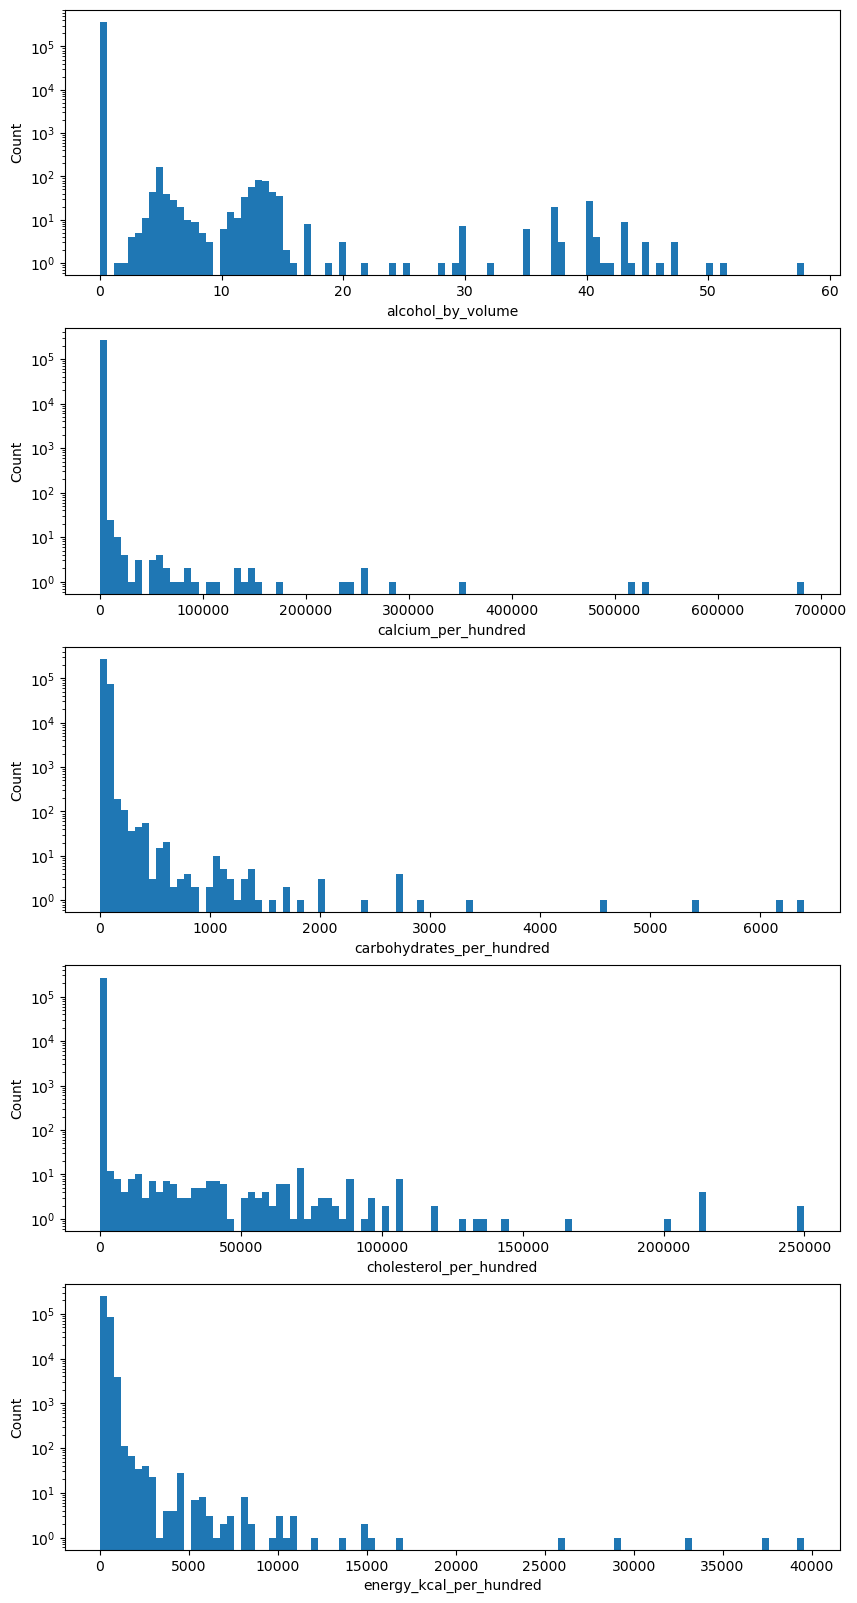

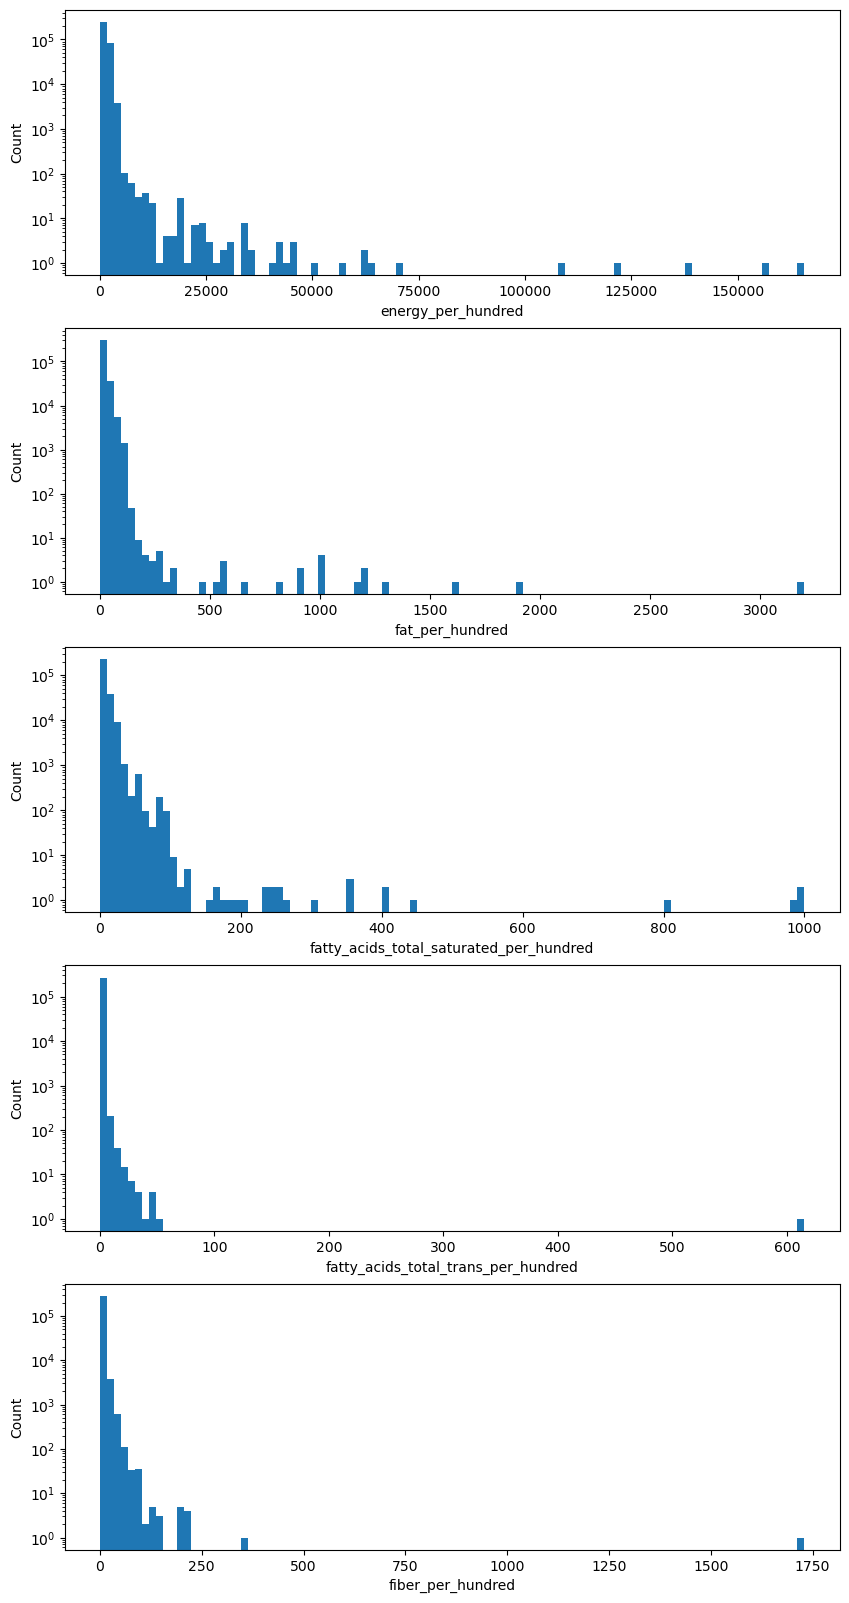

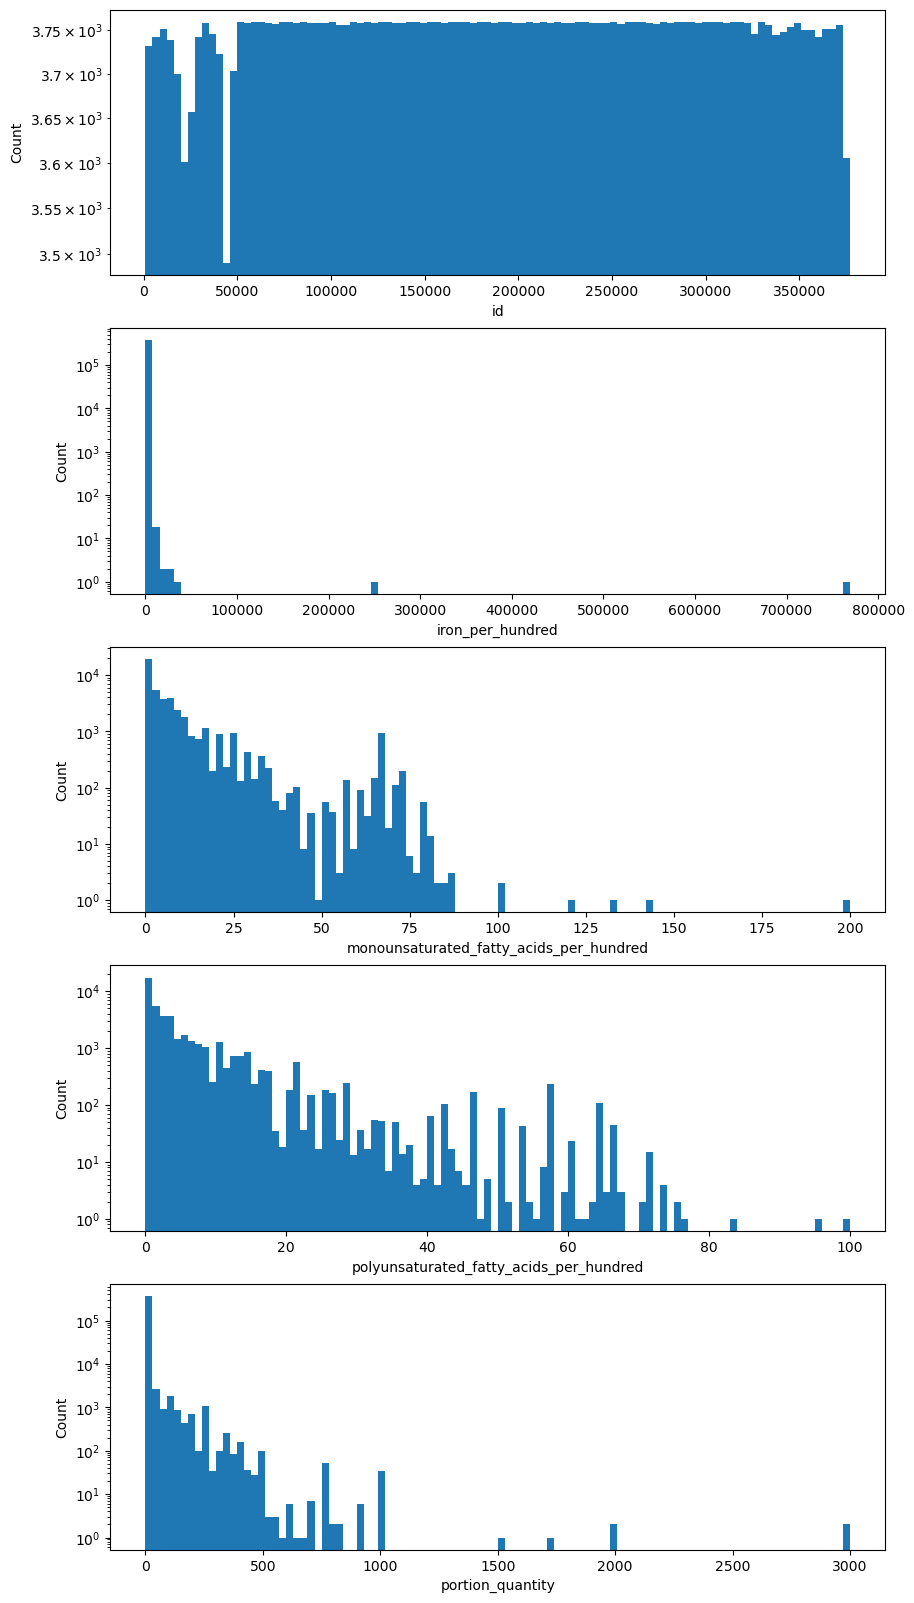

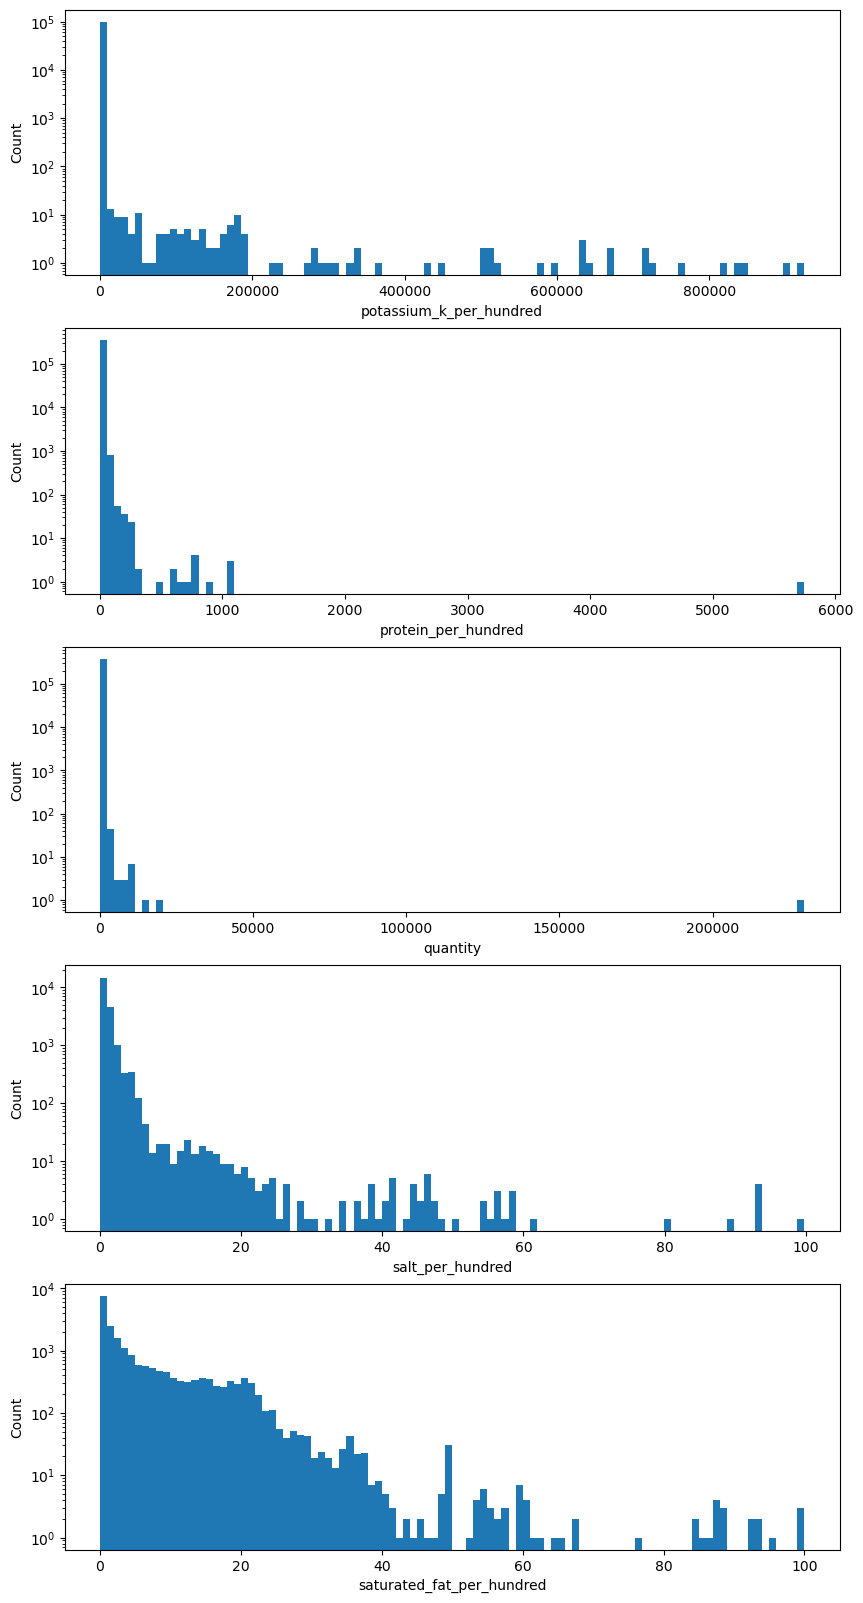

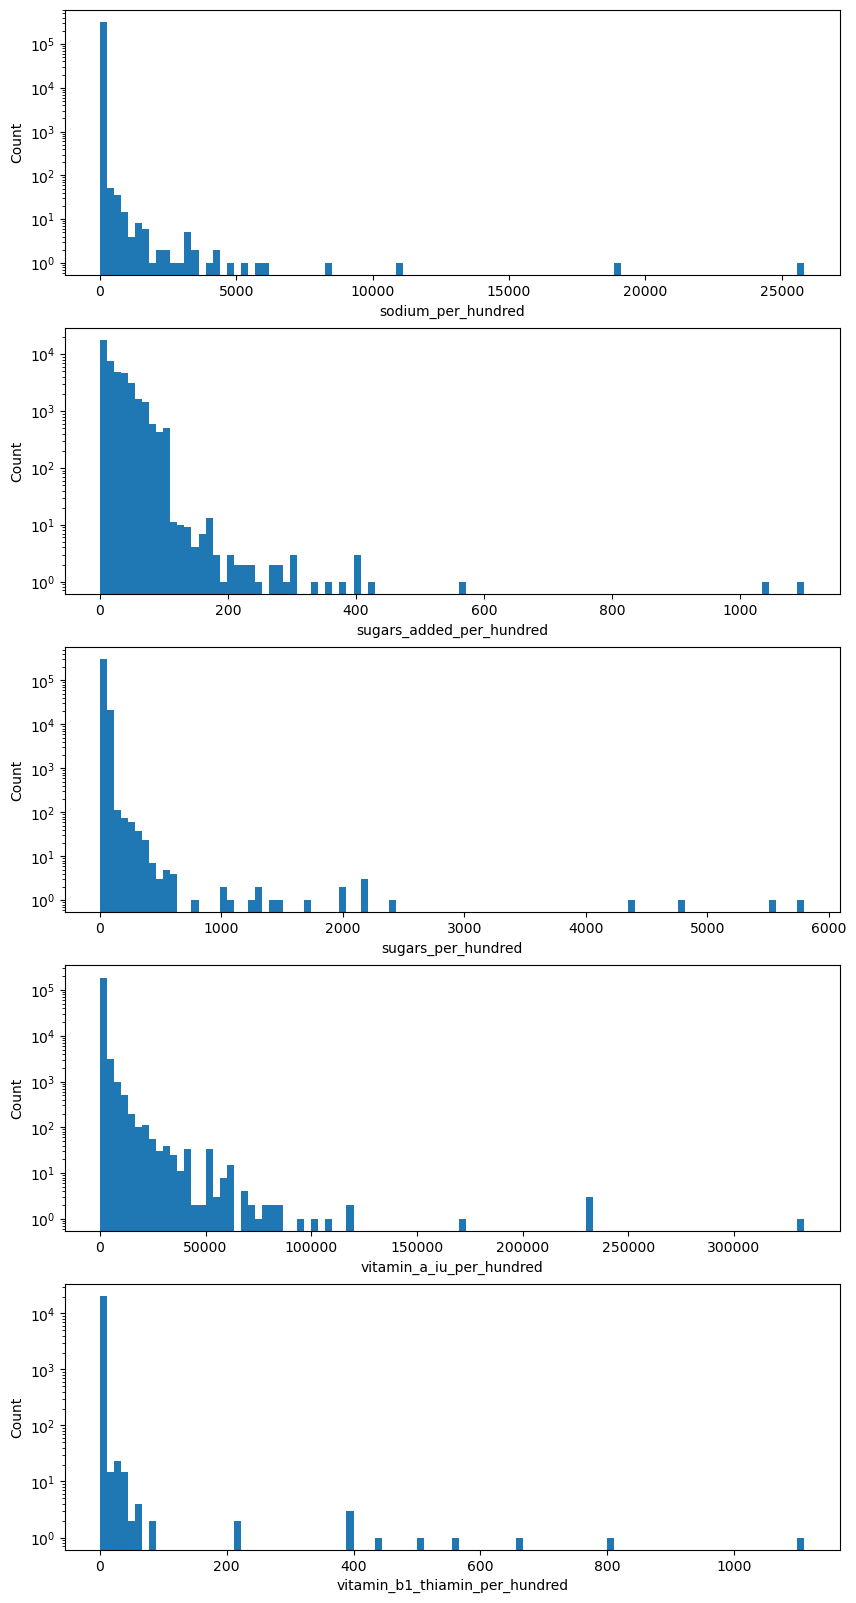

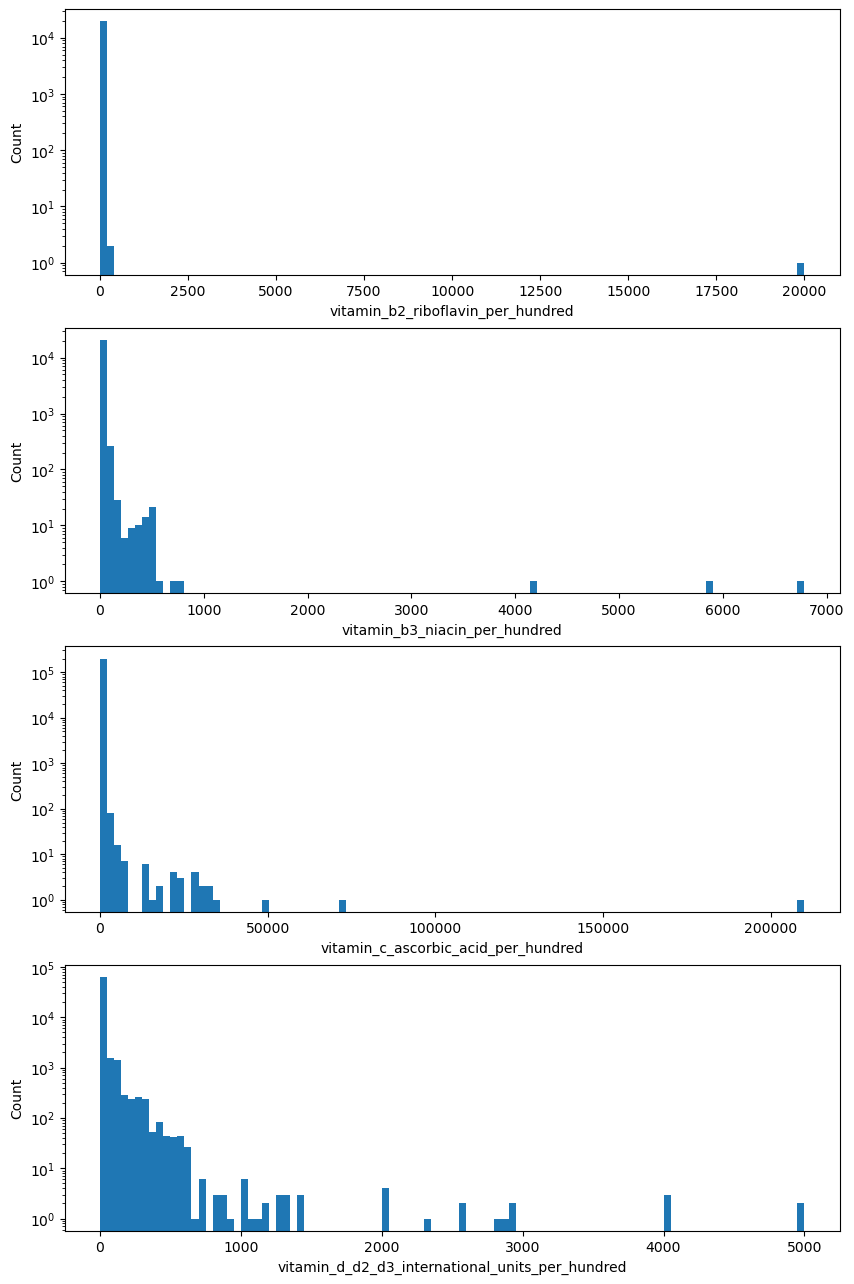

In [45]:
### Visualize the numerical variables in log scale
for j in range(len(numerical_columns)//5 + 1):
    plt.figure(figsize=(10,20))
    for i in range(5):
        if j*5+i >= len(numerical_columns):
            break
        plt.subplot(int(5*100+10+i+1))
        plt.hist(df_dropped[numerical_columns[j*5+i]], bins=100)
        plt.xlabel(numerical_columns[j*5+i])
        plt.ylabel('Count')
        plt.yscale('log')

As shown form the descriptive statistics, comparing the mean and the median expecially, and the histogram, most of the distribution are high skewed and contain values which can be assumed to be outliers.  
There are some variables that have values greater than the maximum available (like `sugars_per_hundred`). It is therefore necessary to correct these errors and subsequently remove the outliers

## 3. Address problematic values
Errors and unrealistic values are a real problem for the reliability of our results. Hence part of the preliminary EDA aims to check for such problematic values. Using the statistics and your plots of the `per_hundred` columns (e.g. `protein_per_hundred`, `fat_per_hundred`, etc.) from previous task, your task is to identify and address these problematic values. Afterwards re-run the descriptive statistics and plots to check everything is ok now.

Below are some additional tips and hints.
- Work with the lists of columns ending in `per_hundred` and `_unit`. Each nutrient should have an associated `per_hundred`-column and a `_unit`-column.
- The range of acceptable values in each `per_hundred`-column depends on the unit given in the associated `_unit`-column.
- As the unit of the `protein_per_hundred` column is g the values in the `protein_per_hundred` column should range between 0 and 100
- If a column's unit is mg, then the values should range between $0$ and $10^{5}$

In [46]:
### Create the new _per_hundred and _unit columns after dropping the columns with missing values
new_columns_per_hundred = []
new_columns_unit = []
for l in df_dropped.columns: 
    if l.endswith(('_per_hundred')):
        new_columns_per_hundred.append(l)
    elif l.endswith(('_unit')):
        new_columns_unit.append(l)

In [47]:
### Check the element that are in the 2 lists
nutrient_per_hundred = [col.replace('_per_hundred', '') for col in new_columns_per_hundred]
nutrient_unit = [col.replace('_unit', '') for col in new_columns_unit]

In [48]:
len(nutrient_per_hundred), len(nutrient_unit)

(25, 39)

Not all the nutrients in `_per_hundred` columns are in the `_unit` columns.  
To find the range in which the values must be base on the `_unit` columns, it is necessary to use only those that are in both lists, finding the intersection between the 2 lists.

In [49]:
### Both the list do not have the same number of elements. 
### Find the element that are in both the lists (intersection between the 2 lists)
nutrient = list(set(nutrient_unit) & set(nutrient_per_hundred))

In [50]:
### Create the new _per_hundred and _unit columns by using the nutrient list
inter_columns_per_hundred = [x+'_per_hundred' for x in nutrient]
inter_columns_unit = [x+'_unit' for x in nutrient]

In [51]:
### Print the unique values in unit columns
df_dropped[inter_columns_unit].apply(lambda x: x.unique()).T

0
sodium_unit                          g
carbohydrates_unit                   g
energy_unit                         kJ
iron_unit                           mg
fat_unit                             g
monounsaturated_fatty_acids_unit     g
vitamin_b2_riboflavin_unit          mg
cholesterol_unit                    mg
sugars_added_unit                    g
protein_unit                         g
potassium_k_unit                    mg
polyunsaturated_fatty_acids_unit     g
energy_kcal_unit                  kCal
fatty_acids_total_saturated_unit     g
fatty_acids_total_trans_unit         g
sugars_unit                          g
vitamin_a_iu_unit                   IU
salt_unit                            g
calcium_unit                        mg
vitamin_b3_niacin_unit              mg
saturated_fat_unit                   g
vitamin_b1_thiamin_unit             mg
fiber_unit                           g
vitamin_c_ascorbic_acid_unit        mg

In [52]:
### Print the maximum and the minimum in the per_hundred columns
df_dropped[inter_columns_per_hundred].describe().loc[['min', 'max']].T

min        max
sodium_per_hundred                       0.0   25833.33
carbohydrates_per_hundred                0.0    6400.00
energy_per_hundred                       0.0  165686.40
iron_per_hundred                         0.0  769230.77
fat_per_hundred                          0.0    3200.00
monounsaturated_fatty_acids_per_hundred  0.0     200.00
vitamin_b2_riboflavin_per_hundred        0.0   20000.00
cholesterol_per_hundred                  0.0  250000.00
sugars_added_per_hundred                 0.0    1100.00
protein_per_hundred                      0.0    5747.00
potassium_k_per_hundred                  0.0  925000.00
polyunsaturated_fatty_acids_per_hundred  0.0     100.00
energy_kcal_per_hundred                  0.0   39600.00
fatty_acids_total_saturated_per_hundred  0.0    1000.00
fatty_acids_total_trans_per_hundred      0.0     615.38
sugars_per_hundred                       0.0    5800.00
vitamin_a_iu_per_hundred                 0.0  333333.00
salt_per_hundred                         0.0      99.80
calcium_per_hundred                      0.0  684000.00
vitamin_b3_niacin_per_hundred            0.0    6785.71
saturated_fat_per_hundred                0.0     100.00
vitamin_b1_thiamin_per_hundred           0.0    1111.00
fiber_per_hundred                        0.0    1730.00
vitamin_c_ascorbic_acid_per_hundred      0.0  210000.00

In [53]:
### Use the max of the values based on the unit
unit_range = {'g': 100, 'mg': 1e5, 'kJ':3700, 'kCal':885, 'IU':3.3e8}

Looking at the descriptive, there are values that exceed the available maximum. Let's print them

In [54]:
### Check how many nutrients have values out of the pre-established range.
### The min is 0 for all the nutrients. Let's check the nutrients that exceed the maximum
print('Nutrients above the established maximum:')
for nut in nutrient:
    if df_dropped[nut+'_per_hundred'].max() > unit_range[df_dropped[nut+'_unit'].unique()[0]]:
        values_above_max = round(100*(df_dropped[nut+'_per_hundred'] > unit_range[df_dropped[nut+'_unit'].unique()[0]]).sum()/df_dropped.shape[0], 4)
        print(f'{nut} has {values_above_max}% of the values above the maximum')

Nutrients above the established maximum:
sodium has 0.0501% of the values above the maximum
carbohydrates has 0.287% of the values above the maximum
energy has 0.2211% of the values above the maximum
iron has 0.0005% of the values above the maximum
fat has 0.0363% of the values above the maximum
monounsaturated_fatty_acids has 0.0011% of the values above the maximum
cholesterol has 0.0059% of the values above the maximum
sugars_added has 0.0256% of the values above the maximum
protein has 0.0459% of the values above the maximum
potassium_k has 0.0216% of the values above the maximum
energy_kcal has 0.2369% of the values above the maximum
fatty_acids_total_saturated has 0.0085% of the values above the maximum
fatty_acids_total_trans has 0.0003% of the values above the maximum
sugars has 0.1182% of the values above the maximum
calcium has 0.0048% of the values above the maximum
fiber has 0.0056% of the values above the maximum
vitamin_c_ascorbic_acid has 0.0003% of the values above the m

The percentage of the nutrients that exceed the maximum is small.  
For this reason I decided to remove them

In [55]:
### Drop rows that exceed the maximum
df_nutr = df_dropped.copy()
for nut in nutrient:
    df_nutr[nut+'_per_hundred'] = df_dropped[df_dropped[nut+'_per_hundred'] <= unit_range[df_dropped[nut+'_unit'].unique()[0]]][nut+'_per_hundred']

In [56]:
df_nutr[inter_columns_per_hundred].describe().loc[['min', 'max']].T

min        max
sodium_per_hundred                       0.0     100.00
carbohydrates_per_hundred                0.0     100.00
energy_per_hundred                       0.0    3700.00
iron_per_hundred                         0.0   35714.29
fat_per_hundred                          0.0     100.00
monounsaturated_fatty_acids_per_hundred  0.0     100.00
vitamin_b2_riboflavin_per_hundred        0.0   20000.00
cholesterol_per_hundred                  0.0  100000.00
sugars_added_per_hundred                 0.0     100.00
protein_per_hundred                      0.0     100.00
potassium_k_per_hundred                  0.0   99000.00
polyunsaturated_fatty_acids_per_hundred  0.0     100.00
energy_kcal_per_hundred                  0.0     885.00
fatty_acids_total_saturated_per_hundred  0.0     100.00
fatty_acids_total_trans_per_hundred      0.0      53.57
sugars_per_hundred                       0.0     100.00
vitamin_a_iu_per_hundred                 0.0  333333.00
salt_per_hundred                         0.0      99.80
calcium_per_hundred                      0.0   93750.00
vitamin_b3_niacin_per_hundred            0.0    6785.71
saturated_fat_per_hundred                0.0     100.00
vitamin_b1_thiamin_per_hundred           0.0    1111.00
fiber_per_hundred                        0.0     100.00
vitamin_c_ascorbic_acid_per_hundred      0.0   71428.60

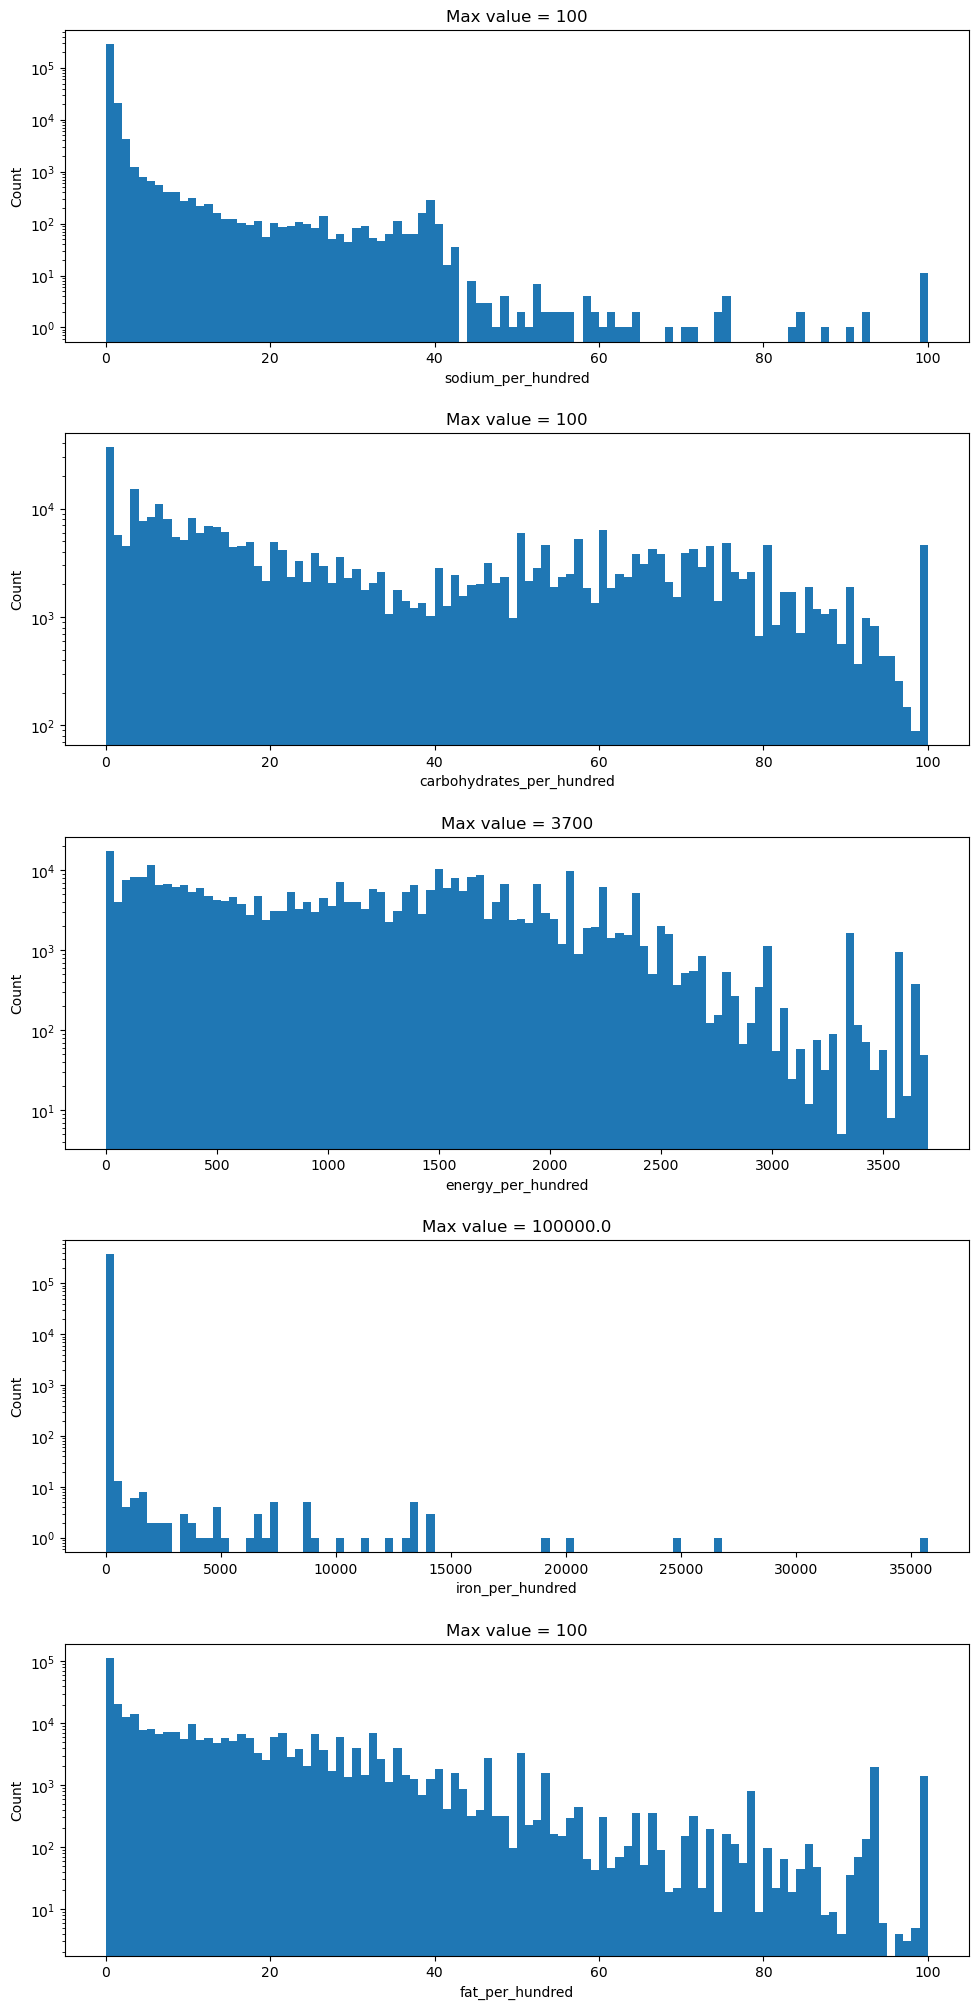

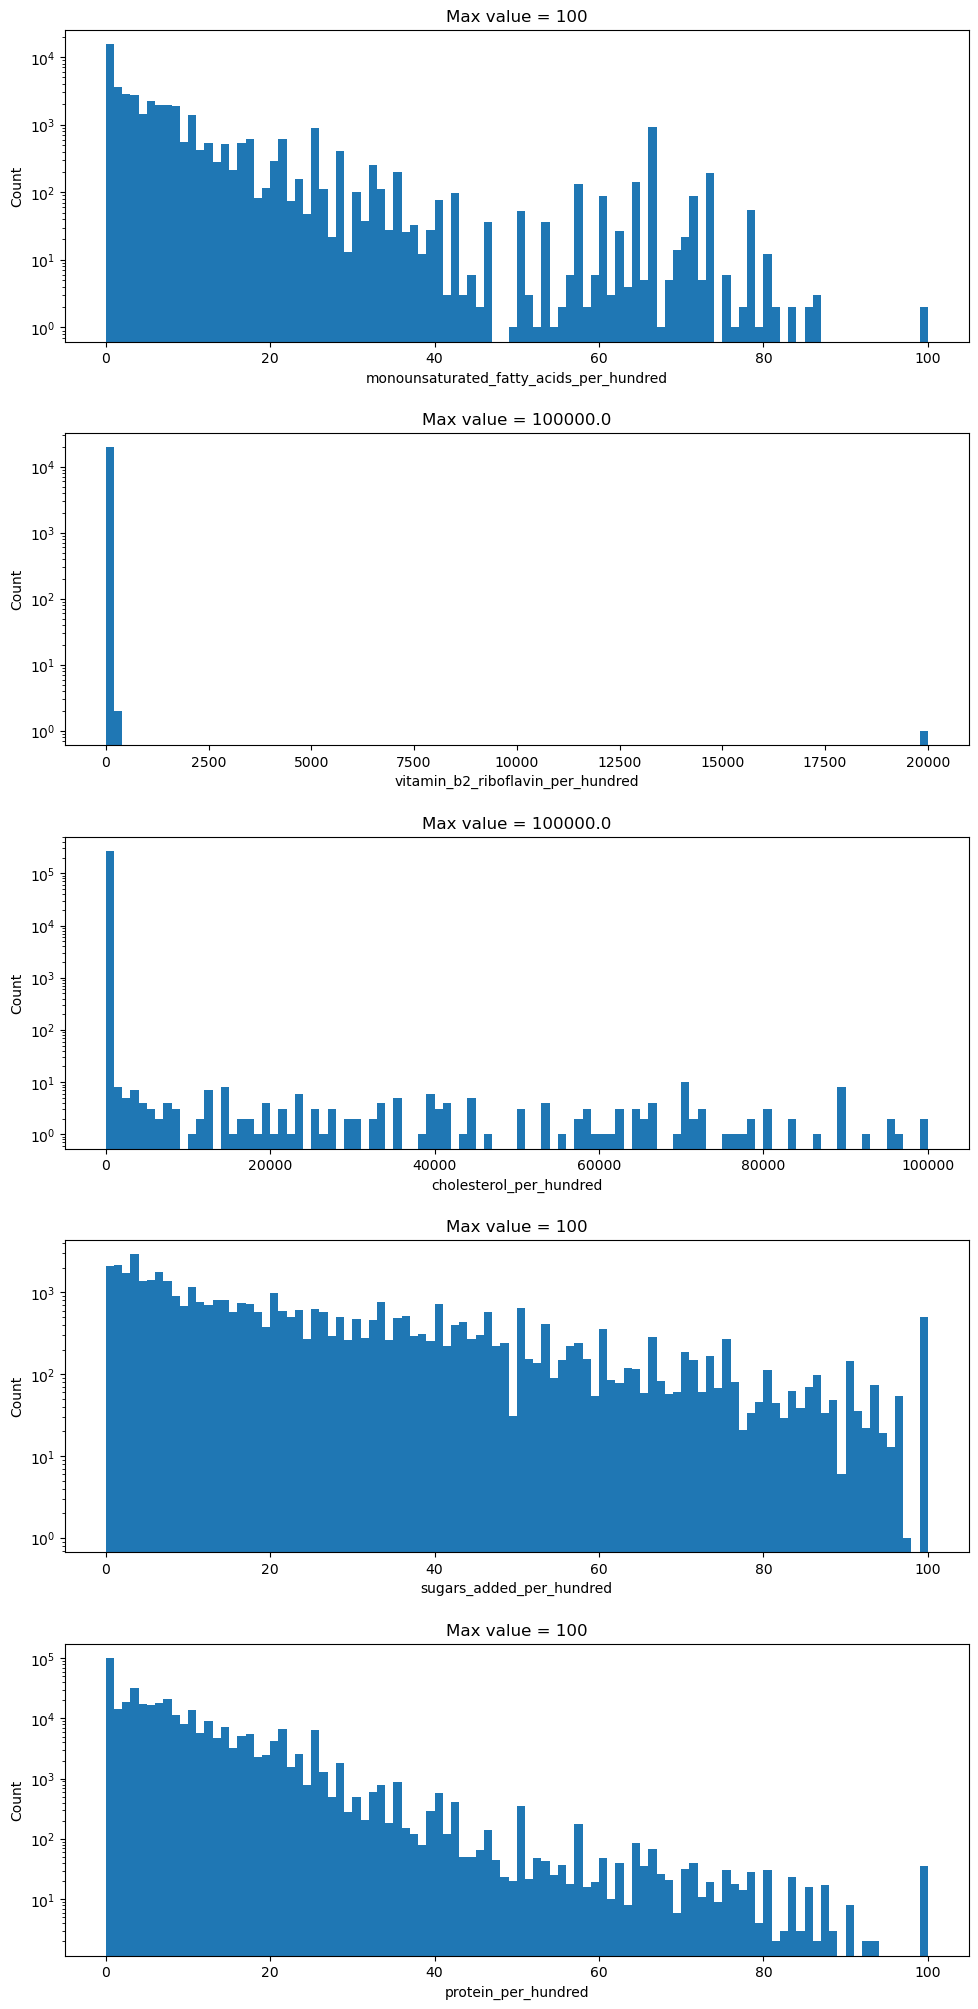

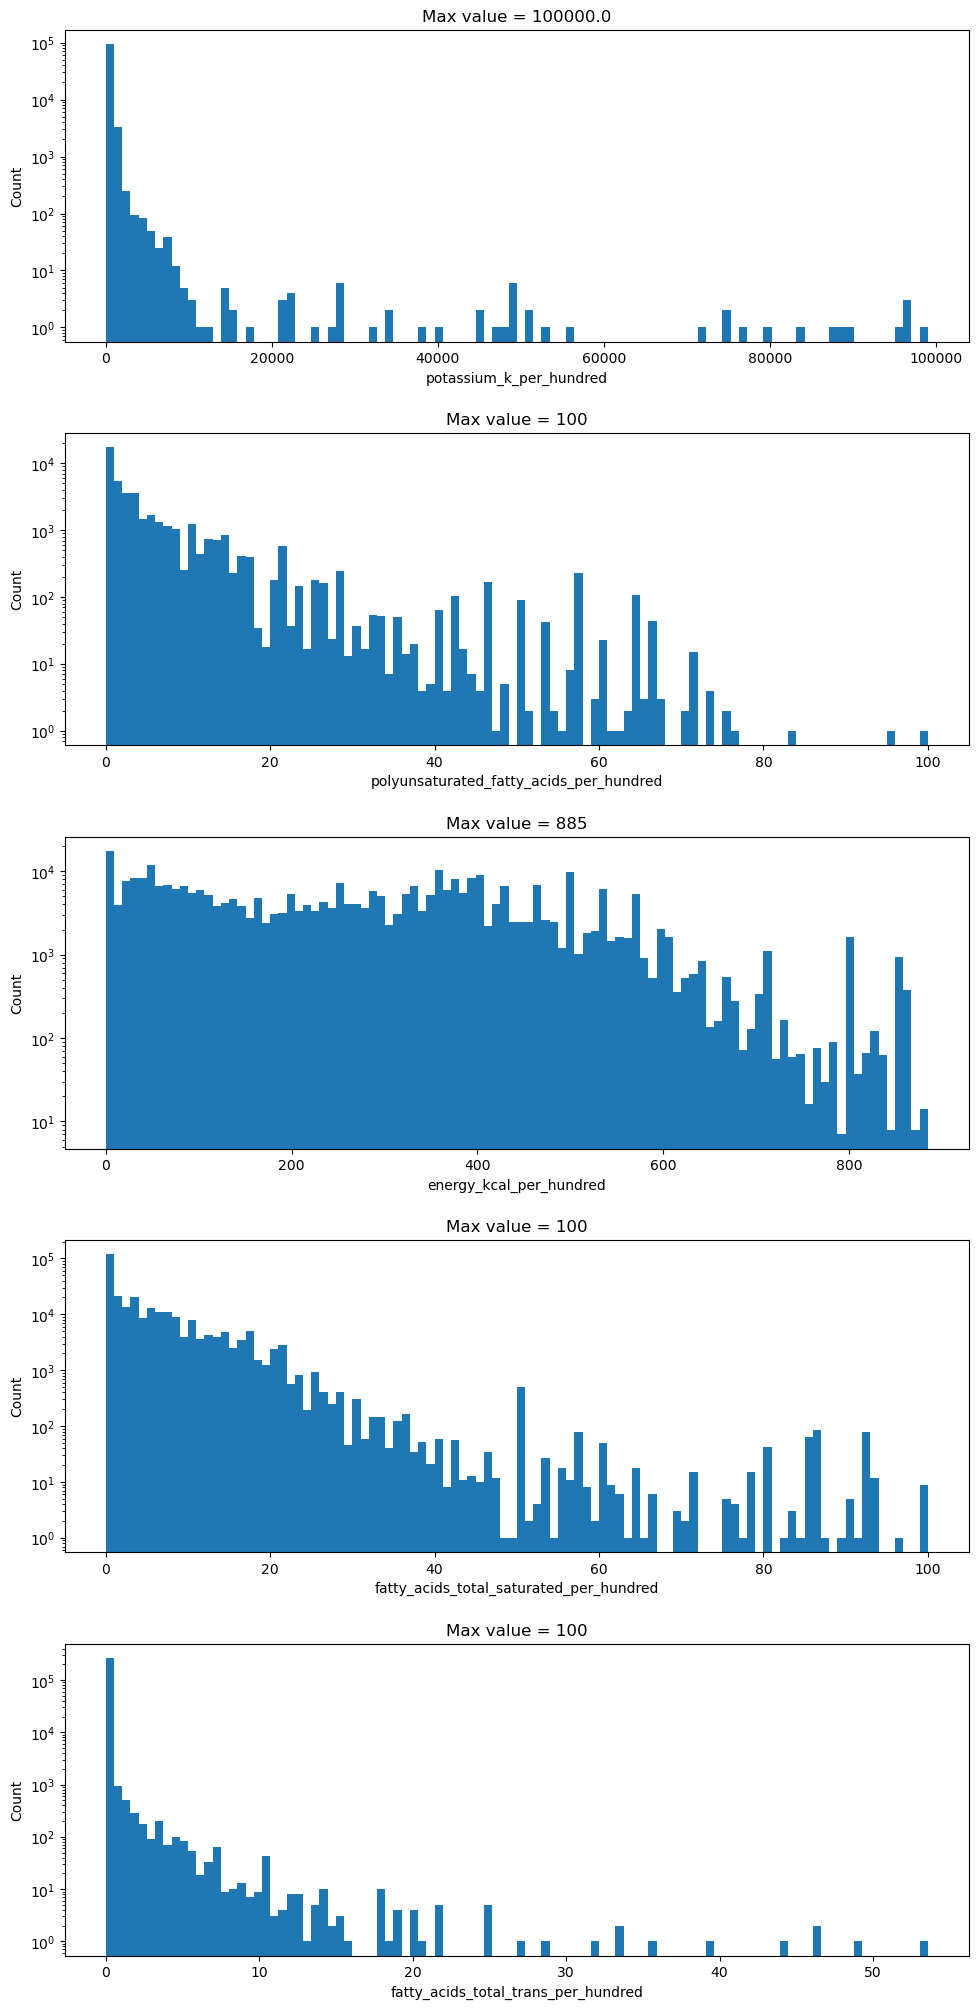

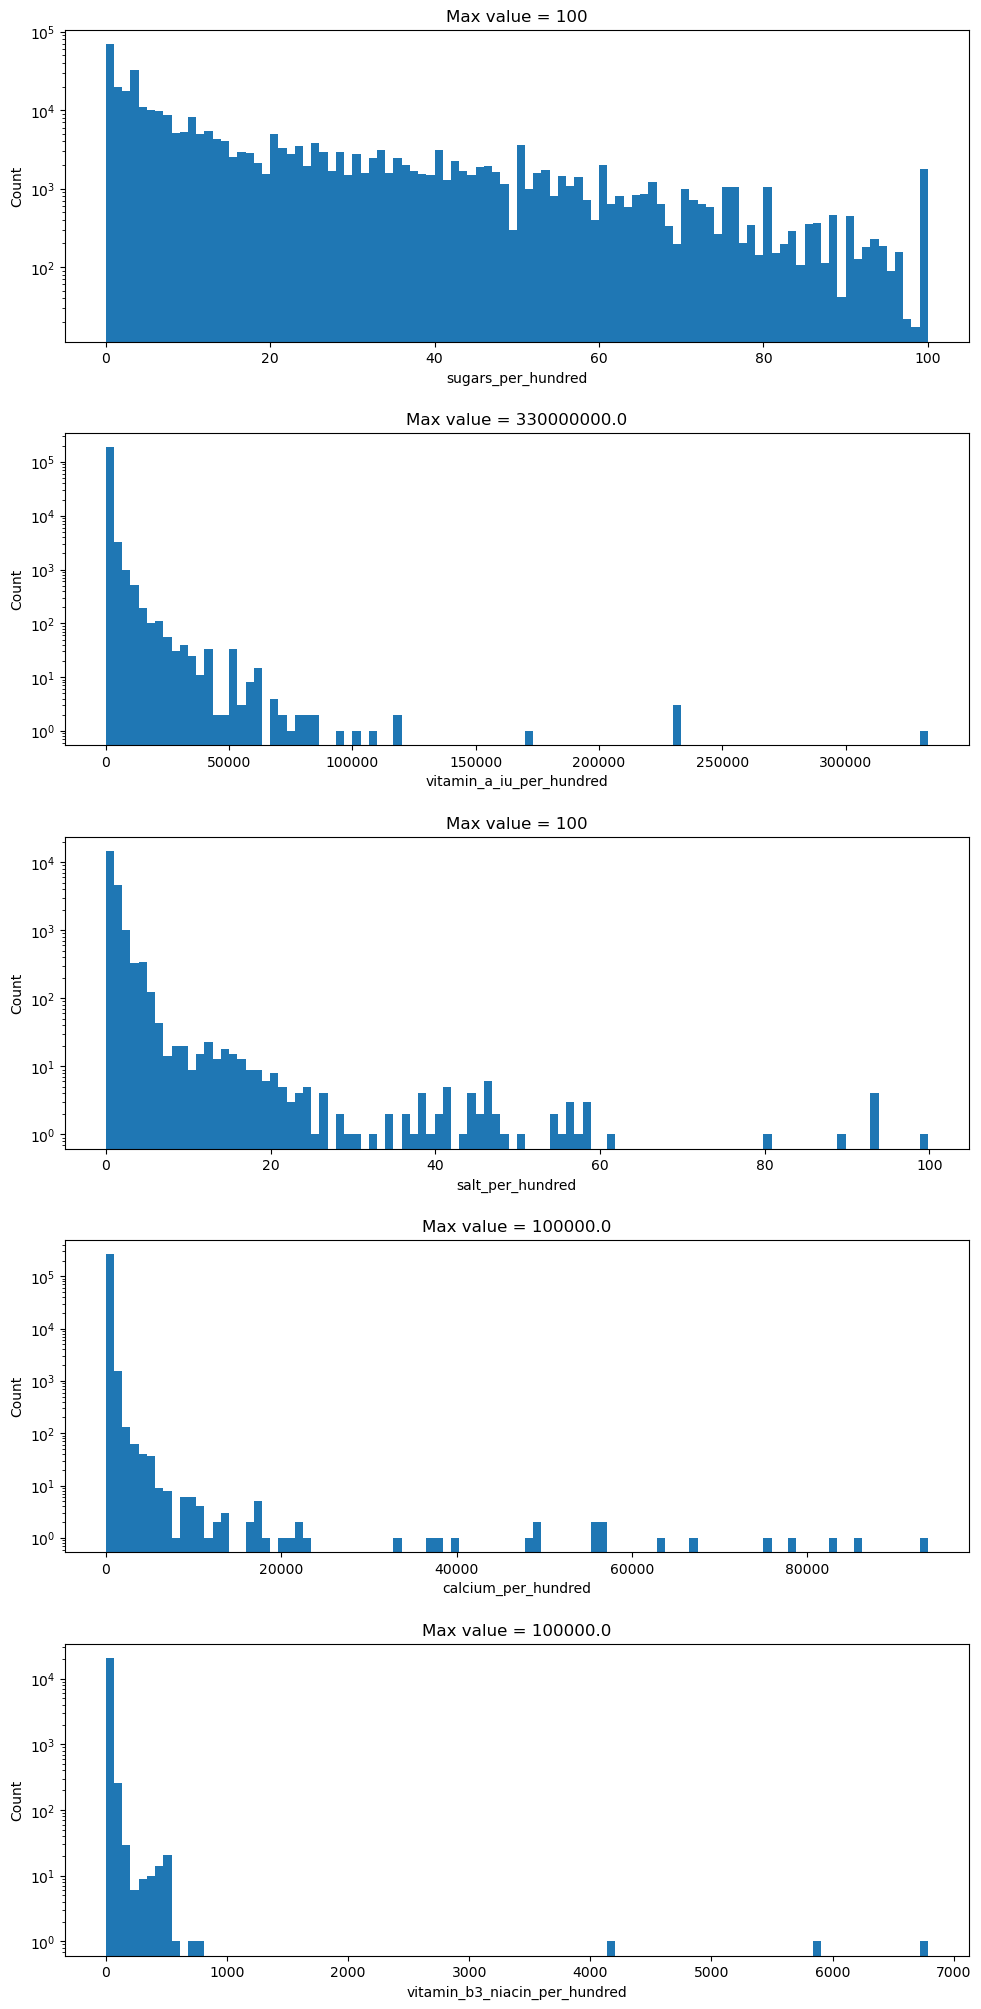

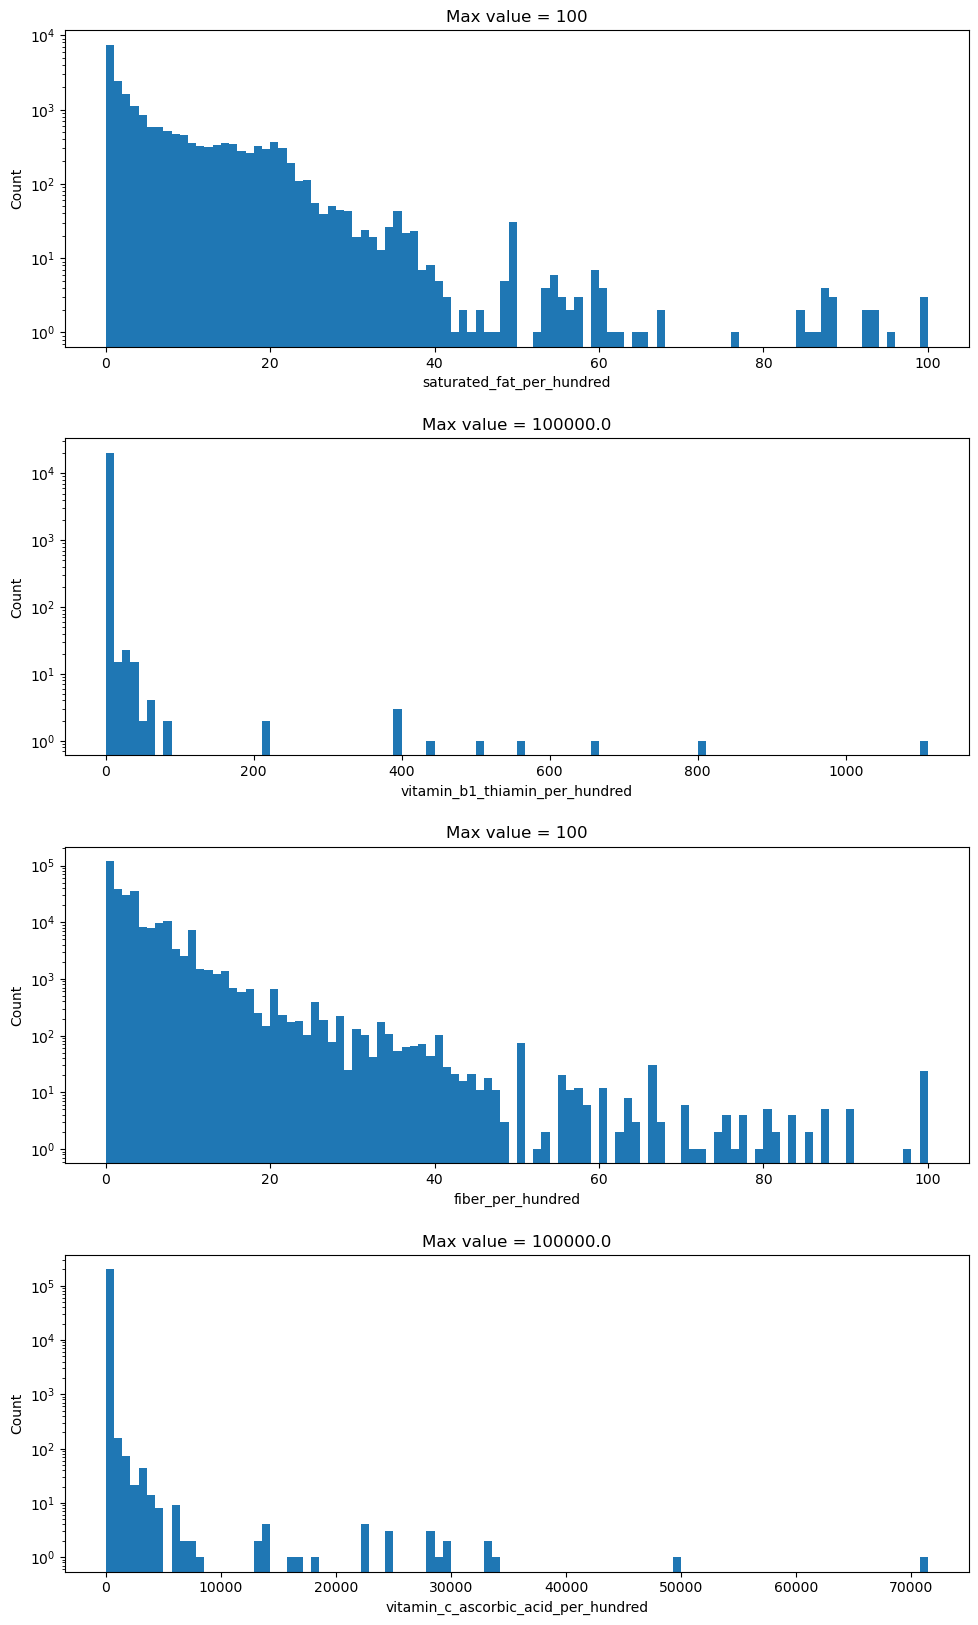

In [57]:
### Visualize the numerical variables in log scale
for j in range(len(inter_columns_per_hundred)//5 + 1):
    plt.figure(figsize=(10,20))
    for i in range(5):
        if j*5+i >= len(inter_columns_per_hundred):
            break
        max_value = unit_range[df_dropped[nutrient[j*5+i]+'_unit'].unique()[0]]
        plt.subplot(int(5*100+10+i+1))
        plt.tight_layout(h_pad=2)
        plt.title(f'Max value = {max_value}')
        plt.hist(df_nutr[inter_columns_per_hundred[j*5+i]], bins=100)
        plt.xlabel(inter_columns_per_hundred[j*5+i])
        plt.ylabel('Count')
        plt.yscale('log')

Exploring the descriptive statistics and the plots the problematic values that exceed the maximum have been fixed.

## 4. Identify and address potential inconsistencies
Columns in our data set may be related to each other or pose constraints on one another. Unfortunately, this may also give rise to inconsistencies. Your task is to investigate the three cases below analytically (including visualizations like scatterplots), identify potential inconsistencies and address them. You should allow for some rounding errors and verify that your approaches have addressed the issues appropriately.s.

### a) Inconsistencies in `_per_hundred`-value
The bulk of most products is made up of the four main macronutrients (fat, protein, carbohydrates and fiber). In the previous subtask we checked that each of their `_per_hundred`-value is at most 100g. We can equally apply the same logic for their combined amount. For example, a product with 64g of carbohydrates, 43g of protein and 12g of fat would give us a total of 119g of macronutrients in 100g of produce. Clearly that is not realistic.

In [58]:
pd.set_option('mode.use_inf_as_na', True)  # convert inf to nan
### Create a list of the four main macronutrients
bulk = ['fat_per_hundred', 'protein_per_hundred', 'carbohydrates_per_hundred', 'fiber_per_hundred']
### Check if the sum of these values exceeds 100
df_nutr[bulk].sum(axis=1).describe()

C:\Users\enric\AppData\Local\Temp\ipykernel_219588\1315134959.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)  # convert inf to nan


count    374884.000000
mean         51.333677
std          37.223748
min           0.000000
25%          15.890000
50%          47.030000
75%          90.782500
max         300.000000
dtype: float64

In [59]:
print(f'{round(df_nutr[df_nutr[bulk].sum(axis=1) > 100].shape[0]/df_nutr.shape[0], 3)}% of the macronutrients sum exceeds 100 g')

0.075% of the macronutrients sum exceeds 100 g


In [60]:
print(f'Shape before dropping: {df_nutr.shape}')

Shape before dropping: (374884, 78)


In [61]:
### Let's remove all the values that sum more then 100
df_bulk = df_nutr[df_nutr[bulk].sum(axis=1) <= 100]

In [62]:
print(f'Shape after dropping: {df_bulk.shape}')

Shape after dropping: (346684, 78)


### b) Relation between `energy_per_hundred` and `energy_kcal_per_hundred` columns
The column `energy_per_hundred` measures the energy content in kJ. Analyze its relationship with the column `energy_kcal_per_hundred`.    

<Axes: xlabel='energy_kcal_per_hundred', ylabel='energy_per_hundred'>

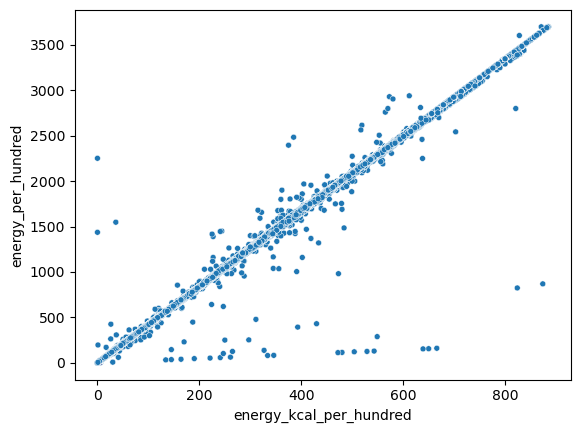

In [63]:
sns.scatterplot(data=df_bulk, x='energy_kcal_per_hundred', y='energy_per_hundred', size=0.1, legend=None)

The columns 'energy_kcal_per_hundred' and 'energy_per_hundred' have a linear relationship because they represent the same quantity expressed in kJ and kCal respectively.  
As shown in the previous plot, there are values far from the line.  
Let's try to fix them

C:\Users\enric\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


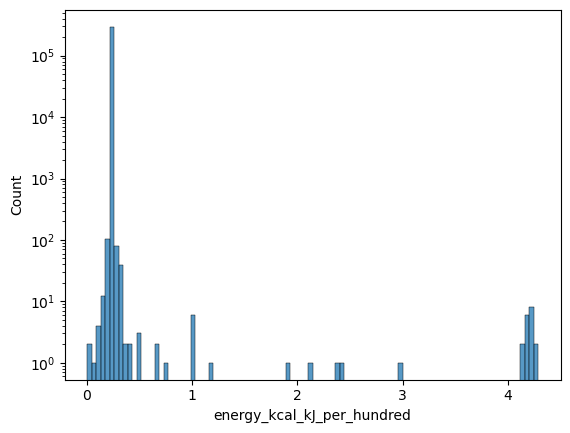

In [64]:
### Keep the elements where the energy for both kJ and kCal are different or equal to zero 
df_bulk = df_bulk[((df_bulk.energy_kcal_per_hundred != 0) & (df_bulk.energy_per_hundred != 0)) | 
                  ((df_bulk.energy_kcal_per_hundred == 0) & (df_bulk.energy_per_hundred == 0))]

### Create a new variable representing the ratio between the energy in kCal and the energy in kJ
df_bulk['energy_kcal_kJ_per_hundred'] = np.nan
df_bulk.loc[:, 'energy_kcal_kJ_per_hundred'] = df_bulk.eval('energy_kcal_per_hundred/energy_per_hundred')

sns.histplot(df_bulk.energy_kcal_kJ_per_hundred.dropna(), bins=100)
a=plt.yscale('log')

Actually, it is not possible to know if the conversion was made from kJ to kCal or vice versa.  
Assuming that the conversion has been done from kJ to kCal, let's fix the `energy_kcal_per_hundred` column.  
Let's analyze the previous histogram:
- The values around 4.2 may represent a wrong converion, instead of multiplying by the conversion factor, they were divided. It is possible to fix them by multiplying them for the square of the conversion factor.  
- The values on 1 may represent a conversion that did not take place. It is possible to fix them by multiplying them for the conversion factor. 

C:\Users\enric\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


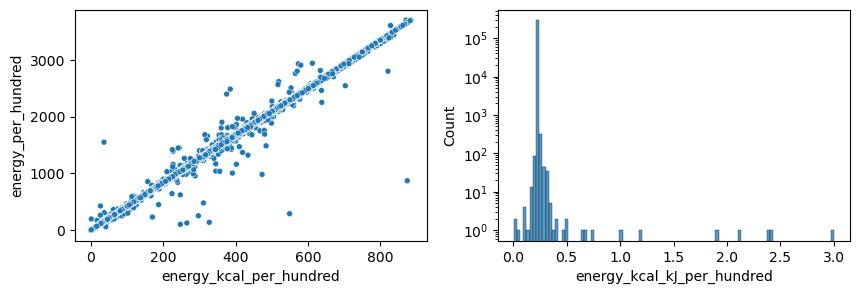

In [65]:
### Compute the conversion factor using the median
conversion_factor = df_bulk.energy_kcal_kJ_per_hundred.median()

### Remove the values higher than 4
df_bulk.loc[df_bulk[df_bulk.energy_kcal_kJ_per_hundred > 4].index, 
             'energy_kcal_per_hundred'] = df_bulk.loc[df_bulk[df_bulk.energy_kcal_kJ_per_hundred > 4].index, 
                                                        'energy_kcal_per_hundred']*conversion_factor**2

### remove the values equal to one
df_bulk.loc[df_bulk[df_bulk.energy_kcal_kJ_per_hundred == 1].index, 
             'energy_kcal_per_hundred'] = df_bulk.loc[df_bulk[df_bulk.energy_kcal_kJ_per_hundred  == 1].index, 
                                                        'energy_kcal_per_hundred']*conversion_factor

### Re-compute the ratio with the new values
df_bulk.loc[:, 'energy_kcal_kJ_per_hundred'] = df_bulk.eval('energy_kcal_per_hundred/energy_per_hundred')

plt.figure(figsize=(10,3))
plt.subplot(121)
sns.scatterplot(data=df_bulk, x='energy_kcal_per_hundred', y='energy_per_hundred', size=0.1, legend=None)
plt.subplot(122)
sns.histplot(df_bulk.energy_kcal_kJ_per_hundred.dropna(), bins=100)
a=plt.yscale('log')

Few values have been fixed, but there are still few inconsistencies.  
As shown in the last histogram, the values on the tail are almost 5 order less than the peak.  
Since these cannot be attributed to wrong conversion, it is convenient to remove them.  
For this, let's apply the following methond:  
- Create a reference energy in kCal obtained by multiplying the `energy_per_hundred` column by the conversion factor.
- Keep all the values that differ $\pm$ 10 kCal from the reference.

In [66]:
### Create and fill 'energy_kcal_per_hundred_ref' column
df_bulk['energy_kcal_per_hundred_ref'] = np.nan
df_bulk.loc[:, 'energy_kcal_per_hundred_ref'] = conversion_factor*df_bulk['energy_per_hundred']

### Keep inly the values in a range of 20 kCal centered in the reference
df_bulk = df_bulk[(df_bulk.energy_kcal_per_hundred > df_bulk.energy_kcal_per_hundred_ref - 10) & 
                  (df_bulk.energy_kcal_per_hundred < df_bulk.energy_kcal_per_hundred_ref + 10)]

<Axes: xlabel='energy_kcal_per_hundred', ylabel='energy_per_hundred'>

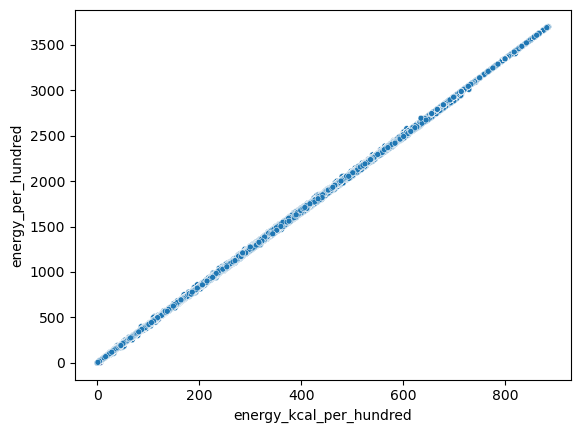

In [67]:
### Plot the relation between 'energy_per_hundred' and 'energy_kcal_per_hundred'
sns.scatterplot(x=df_bulk.energy_kcal_per_hundred, y=df_bulk.energy_per_hundred, size=0.1, legend=None)

In [68]:
df_bulk.shape

(310169, 80)

Now all the inconsistent values have been removed and the relation between `energy_per_hundred` and `energy_kcal_per_hundred` is fully linear.

### c) Compare the energy of the macronutrients with `energy_per_hundred`
Each of the four macronutrients has a specific energy content (fat 37 kJ/g, protein and carbohydrates 17 kJ/g, fibre 8 kJ/g). Calculate the energy provided by these four macronutrients and compare this to the `energy_per_hundred` column. Keep in mind that we are only looking at a subset of all the nutrients.

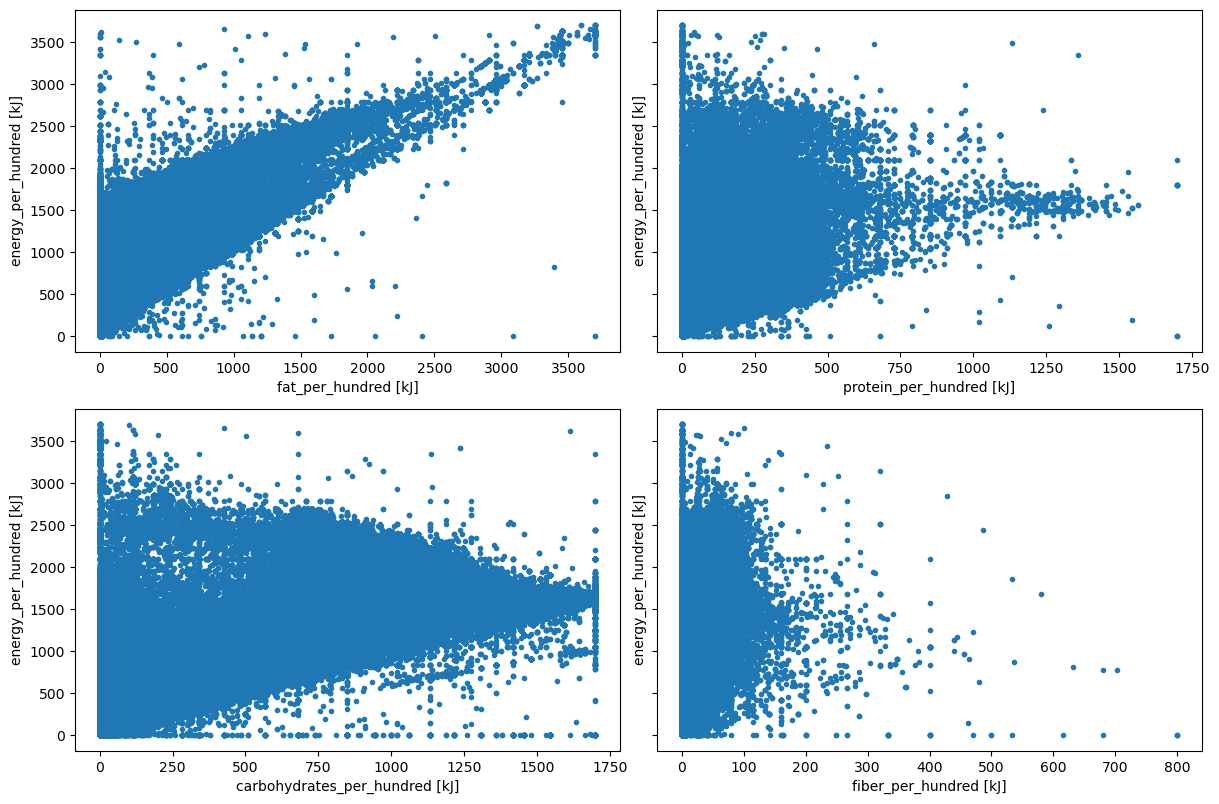

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 2, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.tight_layout(h_pad=2)

energy_macronutrients = {
    'fat_per_hundred': 37, 
    'protein_per_hundred': 17, 
    'carbohydrates_per_hundred': 17, 
    'fiber_per_hundred': 8
}

for i in range(2):
    ax1[i].plot(energy_macronutrients[bulk[i]]*df_bulk[bulk[i]], df_bulk.energy_per_hundred, '.')
    ax1[i].set_ylabel('energy_per_hundred [kJ]')
    ax1[i].set_xlabel(f'{bulk[i]} [kJ]')
    
for i in range(2):
    ax2[i].plot(energy_macronutrients[bulk[i+2]]*df_bulk[bulk[i+2]], df_bulk.energy_per_hundred, '.')
    ax2[i].set_ylabel('energy_per_hundred [kJ]')
    ax2[i].set_xlabel(f'{bulk[i+2]} [kJ]')

With the exception of fat_per_hundred, which may show a dependency, the other macronutrients do not show a dependency with energy.  
The data cut that can be noticed is due to the fact that, in the previous tasks, data above a certain threshold were removed.

The values in `energy_per_hundred` must be equal or higher the sum of all the macronutrients.  
It can be higher because there might be a nutrient that give energy that is not in the four macronutrients.

In [70]:
### Create a column made by the sum of all macronutrients
df_bulk['macronutrients_per_hundred'] = df_bulk.eval('37*fat_per_hundred + 17*protein_per_hundred + \
                                                     17*carbohydrates_per_hundred + 8*fiber_per_hundred')

<Axes: xlabel='macronutrients_per_hundred', ylabel='energy_per_hundred'>

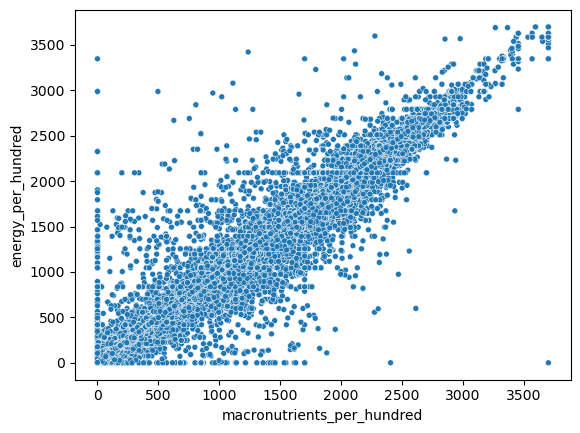

In [71]:
sns.scatterplot(data=df_bulk, x='macronutrients_per_hundred', y='energy_per_hundred', size=0.1, legend=None)

As shown in the plot, the total energy increases as the energy of the macronutrients increases.  
All the values where the macronutrient energy is bigger than the total energy are inconsistents and have to be removed from the analysis.

In [72]:
df_bulk = df_bulk[df_bulk.macronutrients_per_hundred <= df_bulk.energy_per_hundred]

In [73]:
df_bulk.shape

(76909, 81)

<Axes: xlabel='macronutrients_per_hundred', ylabel='energy_per_hundred'>

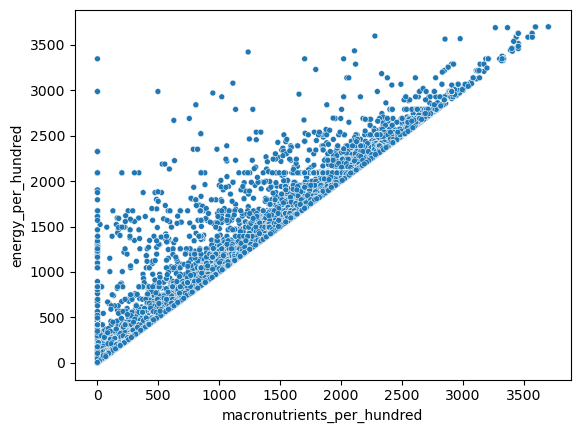

In [74]:
sns.scatterplot(x=df_bulk.macronutrients_per_hundred, y=df_bulk.energy_per_hundred, size=0.1, legend=None)

As said before, there might be some nutrients that give energy that are not in the four macronutrients.  
For this reason, all the values where the total energy is bigger have been kept, even is the sum of macronutrients is zero.  
Now, let's visualize again the relation between the macronutrients and the energy

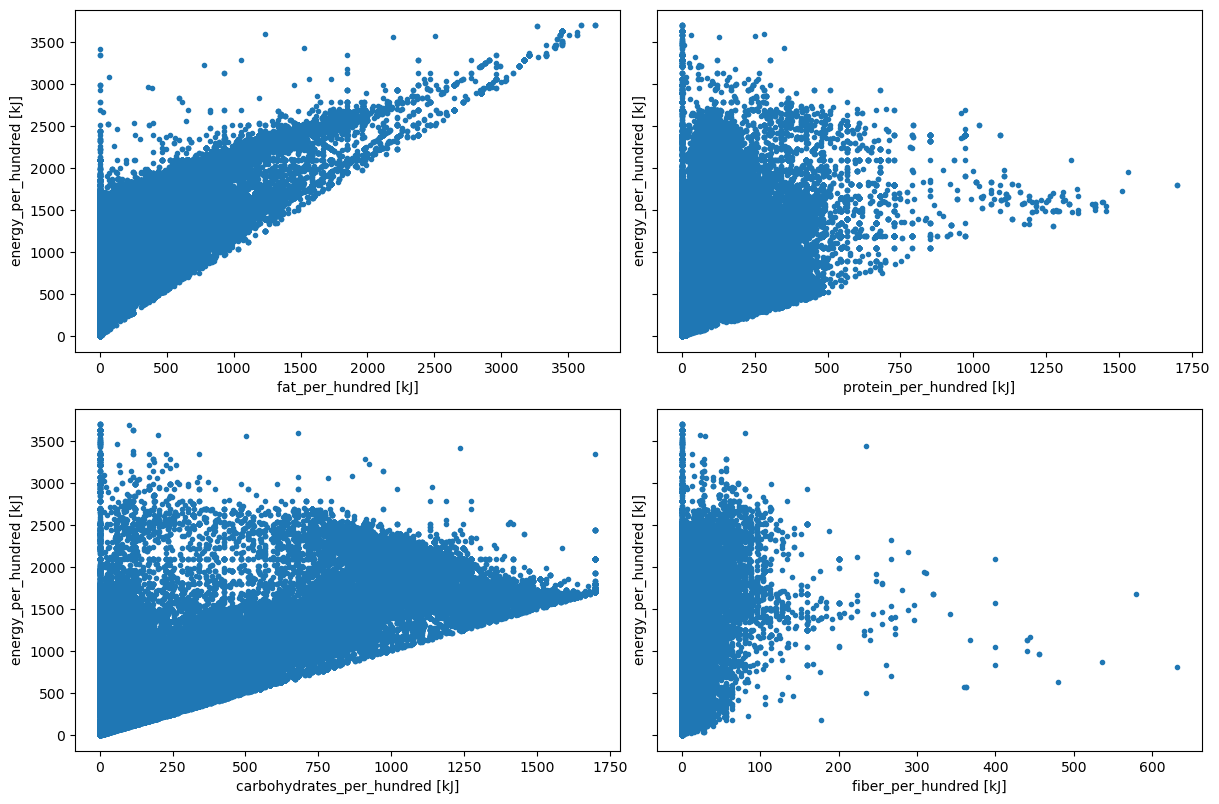

In [75]:
fig, (ax1, ax2) = plt.subplots(2, 2, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.tight_layout(h_pad=2)

energy_macronutrients = {
    'fat_per_hundred': 37, 
    'protein_per_hundred': 17, 
    'carbohydrates_per_hundred': 17, 
    'fiber_per_hundred': 8
}

for i in range(2):
    ax1[i].plot(energy_macronutrients[bulk[i]]*df_bulk[bulk[i]], df_bulk.energy_per_hundred, '.')
    ax1[i].set_ylabel('energy_per_hundred [kJ]')
    ax1[i].set_xlabel(f'{bulk[i]} [kJ]')
    
for i in range(2):
    ax2[i].plot(energy_macronutrients[bulk[i+2]]*df_bulk[bulk[i+2]], df_bulk.energy_per_hundred, '.')
    ax2[i].set_ylabel('energy_per_hundred [kJ]')
    ax2[i].set_xlabel(f'{bulk[i+2]} [kJ]')

## 5. Address outliers
Despite removing recording errors from the `per_hundred` columns, some of them still contain “extreme” values, which are distinct from the rest of the data points. Your goal is to pick a few variables from the `per_hundred` list and address outliers. Be mindful that some outlier detection approaches are not reliable when the underlying variables are strongly skewed.

To remove outliers, let's compute the skewness of the `per_hundred` columns and visualize them.  
The **z-score** method does not work for strongly skewed variables.  
When this happen, it is necessary to remove outliers manually

In [76]:
### Create a dictionary with the skewness of the _per_hundred columns
skewness_dict = {}
for x in inter_columns_per_hundred: 
    skewness_dict[x] = stats.skew(df_bulk[x], nan_policy='omit')

In [77]:
### Sort the column names by the skewness
sorted(skewness_dict.items(), key=lambda x:x[1], reverse=True)

[('iron_per_hundred', 133.59459446191556),
 ('calcium_per_hundred', 90.55322737482429),
 ('vitamin_c_ascorbic_acid_per_hundred', 54.192884302000635),
 ('potassium_k_per_hundred', 53.21683210088255),
 ('vitamin_b3_niacin_per_hundred', 47.13855742782608),
 ('vitamin_b1_thiamin_per_hundred', 47.036094683731726),
 ('cholesterol_per_hundred', 46.924704503808826),
 ('vitamin_a_iu_per_hundred', 40.31025842475947),
 ('fatty_acids_total_trans_per_hundred', 32.15458077822125),
 ('vitamin_b2_riboflavin_per_hundred', 27.671225325796517),
 ('salt_per_hundred', 17.671138089002685),
 ('sodium_per_hundred', 11.483029089712359),
 ('fiber_per_hundred', 6.559385887532133),
 ('monounsaturated_fatty_acids_per_hundred', 4.34861425414966),
 ('polyunsaturated_fatty_acids_per_hundred', 3.379210763487626),
 ('fatty_acids_total_saturated_per_hundred', 2.5975357391951954),
 ('saturated_fat_per_hundred', 1.9012434600878794),
 ('protein_per_hundred', 1.8968095195558443),
 ('sugars_per_hundred', 1.8369321046991993),

C:\Users\enric\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\enric\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\enric\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\enric\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

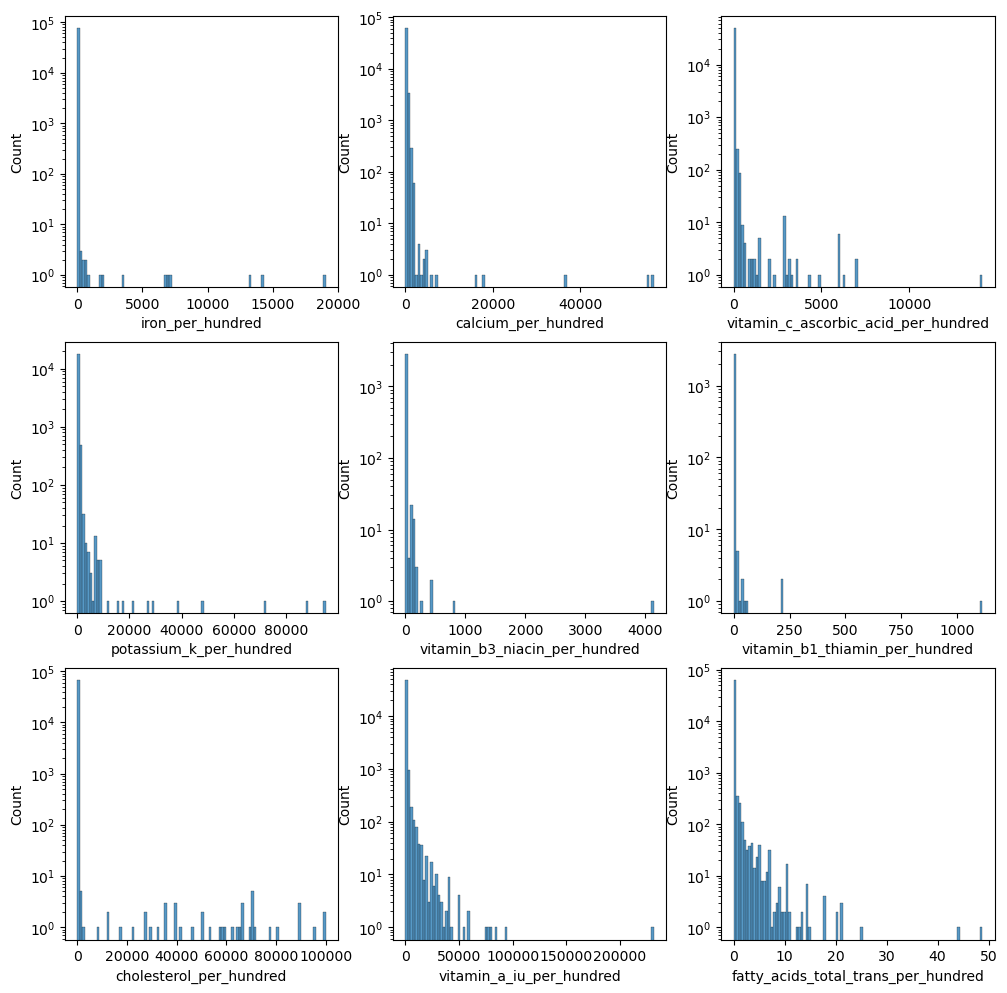

In [78]:
### Visualize the 9 highest skewness columns
plt.figure(figsize=(12,12))
plt.subplot(331)
sns.histplot(df_bulk.iron_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(332)
sns.histplot(df_bulk.calcium_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(333)
sns.histplot(df_bulk.vitamin_c_ascorbic_acid_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(334)
sns.histplot(df_bulk.potassium_k_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(335)
sns.histplot(df_bulk.vitamin_b3_niacin_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(336)
sns.histplot(df_bulk.vitamin_b1_thiamin_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(337)
sns.histplot(df_bulk.cholesterol_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(338)
sns.histplot(df_bulk.vitamin_a_iu_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(339)
sns.histplot(df_bulk.fatty_acids_total_trans_per_hundred, bins=100)
a=plt.yscale('log')

From the histograms above, these variables have values with very low frequency.  
It is possible to remove these values by defining a limit manually:
- `iron_per_hundred` = 60 
- `calcium_per_hundred` = 3000
- `vitamin_c_ascorbic_acid_per_hundred` = 1000
- `potassium_k_per_hundred` = 10000
- `vitamin_b3_niacin_per_hundred` = 200
- `vitamin_b1_thiamin_per_hundred` = 10
- `cholesterol_per_hundred` = 700
- `vitamin_a_iu_per_hundred` = 4000
- `fatty_acids_total_trans_per_hundred` = 15

In [79]:
df_out = df_bulk.copy()

### Remove outliers
df_out.loc[:, 'iron_per_hundred'] = df_out[(df_out.iron_per_hundred < 60)]
df_out.loc[:, 'calcium_per_hundred'] = df_out[df_out.calcium_per_hundred < 3000]
df_out.loc[:, 'vitamin_c_ascorbic_acid_per_hundred'] = df_out[df_out.vitamin_c_ascorbic_acid_per_hundred < 1000]
df_out.loc[:, 'potassium_k_per_hundred'] = df_out[df_out.potassium_k_per_hundred < 10000]
df_out.loc[:, 'vitamin_b3_niacin_per_hundred'] = df_out[df_out.vitamin_b3_niacin_per_hundred < 200]
df_out.loc[:, 'vitamin_b1_thiamin_per_hundred'] = df_out[df_out.vitamin_b1_thiamin_per_hundred < 10]
df_out.loc[:, 'cholesterol_per_hundred'] = df_out[df_out.cholesterol_per_hundred < 700]
df_out.loc[:, 'vitamin_a_iu_per_hundred'] = df_out[df_out.vitamin_a_iu_per_hundred < 40000]
df_out.loc[:, 'fatty_acids_total_trans_per_hundred'] = df_out[df_out.fatty_acids_total_trans_per_hundred < 15]

C:\Users\enric\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\enric\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\enric\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\enric\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

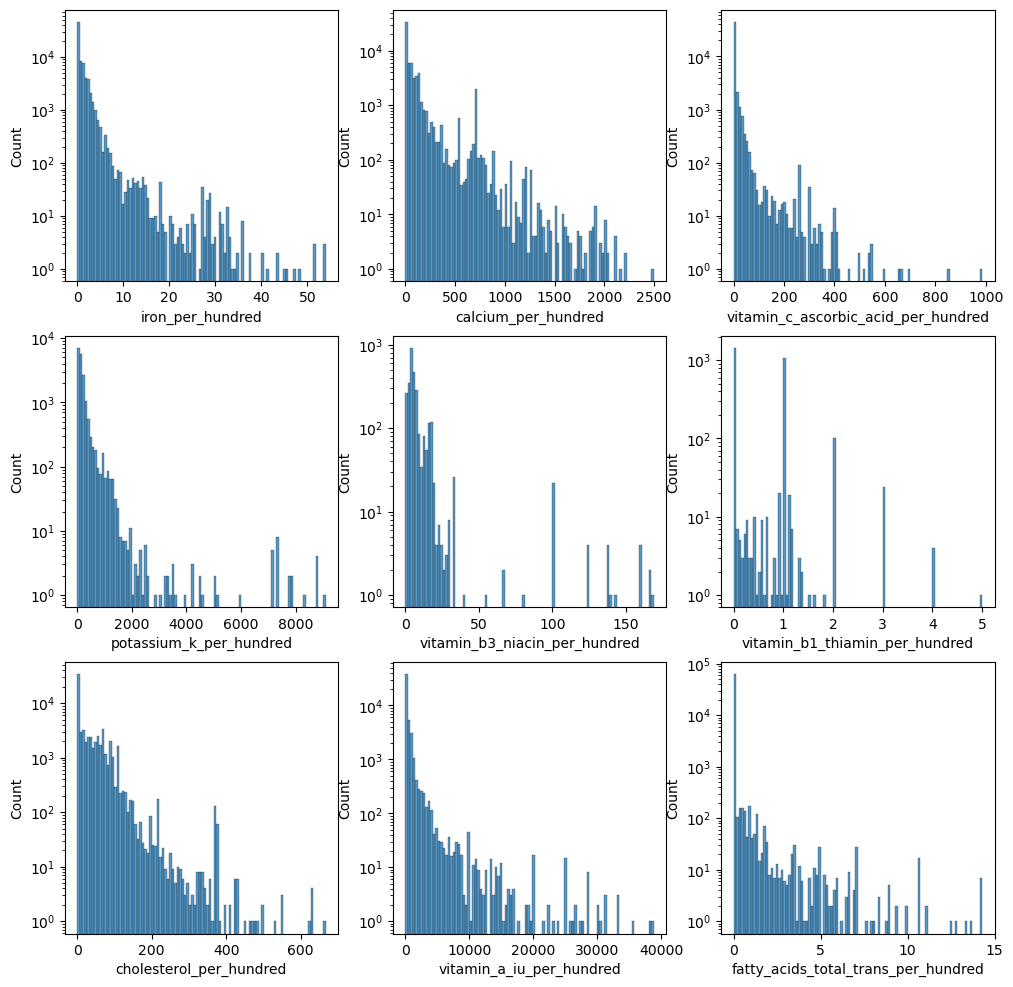

In [80]:
### Visualize the 9 highest skewness columns after removing outliers
plt.figure(figsize=(12,12))
plt.subplot(331)
sns.histplot(df_out.iron_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(332)
sns.histplot(df_out.calcium_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(333)
sns.histplot(df_out.vitamin_c_ascorbic_acid_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(334)
sns.histplot(df_out.potassium_k_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(335)
sns.histplot(df_out.vitamin_b3_niacin_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(336)
sns.histplot(df_out.vitamin_b1_thiamin_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(337)
sns.histplot(df_out.cholesterol_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(338)
sns.histplot(df_out.vitamin_a_iu_per_hundred, bins=100)
a=plt.yscale('log')
plt.subplot(339)
sns.histplot(df_out.fatty_acids_total_trans_per_hundred, bins=100)
a=plt.yscale('log')

From the last histograms it is shown that most of the extreme values have been removed.  

# D) EDA: Text data

## 0. Text preprocessing

In [81]:
df_text = df_out.copy()
### Create 'ingredient_en_list' column for preprocessing
df_text['ingredients_en_list'] = df_text['ingredients_en']
### Remove the products with 'ingredient missing'
df_text = df_text[df_text.ingredients_en_list != 'ingredient_missing']
df_text.shape

### Convert all the words in lowercase
df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.str.lower()

### Remove all parenthesis
# df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.str.replace('{', ',', regex=True).replace('}', ',', regex=True)
# df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.str.replace("(", ',').replace(")", ',')

df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.str.replace(r'\{[^{}]*\}', ',', regex=True)
df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.str.replace(r'\([^()]*\)', ',', regex=True)

### Remove all the symbols and number except commas
df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.str.replace(r"\r\n|:", ',', regex=True)
df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.str.replace("[^\w,]|[0-9]", " ", regex=True)
df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.str.replace("contains|consist", ",", regex=True)

### Split the ingredients list
df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.str.split(',').apply(lambda x: [item.strip() for item in x])
df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.apply(lambda x: [item for item in x if item != ''])

df_text = df_text.reset_index(drop=True)

for i in range(10):
    print(i, df_text.ingredients_en_list[i])

0 ['powdered chocolate', 'emulsifier', 'flavour', 'cinnamon       cocoa minimum']
1 ['cocoa paste', 'raw cane sugar', 'cocoa butter', 'vanilla beans    cocoa content of chocolate', 'minimum', 'ingredients in accordance with fairtrade fairtrade standards      of the total weight  of which products cocoa base sugars with mass balance', 'all agricultural ingredients come from farms that are being converted to organic farming']
2 ['sugar', 'whole milk powder', 'cocoa butter', 'cocoa mass', 'honey', 'concentrated butter', 'almonds', 'emulsifier', 'egg white', 'flavoring', 'cocoa', 'minimum in milk chocolate']
3 ['honey']
4 ['organic dates', 'organic coconut', 'organic cashew nuts', 'organic whole milk', 'organic amaranth', 'organic apple cider vinegar', 'organic coconut oil']
5 ['popped corn', 'rapeseed oil', 'sea salt  may contain un popped kernels']
6 ['popped corn', 'rapeseed oil', 'sugar', 'rice flour', 'buttermilk', 'natural flavourings', 'salt', 'coconut milk', 'vanill extract  may co

From the previous products listed, can be noticed that not all the elements are ingredients. For example, in the printed ingredient lists there are the followings that are not ingredients:

- _superior quality durum wheat pasta_
- _ingredients_
- _all agricultural ingredients are products of organic farming_
- _ingredients in accordance with fairtrade fairtrade standards      of the total weight  of which products cocoa base sugars with mass balance_
- _all agricultural ingredients come from farms that are being converted to organic farming_
- _traded in compliance with fairtrade standards_

These are descriptions but they are treated as single ingredients.  
Assuming that the combination of words in these elements is such that they have a low frequency, we print the frequency with which an ingredient appears.  
Few stop words appear in the previous examples.  
One way to solve this problem is to find common words that are not ingredients and remove all the element that contains these words.

In [82]:
### Let's identify few words to remove
word_to_remove = ['superior', 'quality', 'ingredient', 'product', 'fairtrade', 'contain', 'traded', 'compliance', 'minimum', 'less', '_']

In [83]:
df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.apply(
    lambda x: [item for item in x if all(word not in item for word in word_to_remove)]
)

In [84]:
import pycountry
### Create a list of countries
list_of_conutries = [country.name.lower() for country in pycountry.countries]
### Remove all the countries in the ingredients
df_text.loc[:, 'ingredients_en_list'] = df_text.ingredients_en_list.apply(lambda x: [word for word in x if word not in list_of_conutries])

In [85]:
df_text = df_text[df_text.ingredients_en_list.apply(lambda x: len(x) > 0)]
df_text = df_text.reset_index(drop=True)

In [86]:
for i in range(10):
    print(i, df_text.ingredients_en_list[i])

0 ['powdered chocolate', 'emulsifier', 'flavour']
1 ['cocoa paste', 'raw cane sugar', 'cocoa butter', 'vanilla beans    cocoa content of chocolate']
2 ['sugar', 'whole milk powder', 'cocoa butter', 'cocoa mass', 'honey', 'concentrated butter', 'almonds', 'emulsifier', 'egg white', 'flavoring', 'cocoa']
3 ['honey']
4 ['organic dates', 'organic coconut', 'organic cashew nuts', 'organic whole milk', 'organic amaranth', 'organic apple cider vinegar', 'organic coconut oil']
5 ['popped corn', 'rapeseed oil']
6 ['popped corn', 'rapeseed oil', 'sugar', 'rice flour', 'buttermilk', 'natural flavourings', 'salt', 'coconut milk']
7 ['almonds', 'raisins', 'cashew', 'nuts', 'papaya', 'pineapple', 'pistachio']
8 ['potatoes', 'sunflower oil', 'sea salt']
9 ['potatoes', 'sunflower oil', 'spice preparation  maltodextrin', 'dextrose', 'salt', 'paprika powder', 'yeast extract', 'onion powder', 'potato starch', 'dye', 'flavoring smoke', 'spice extract', 'natural flavor']


## 1. Longest ingredients list
Find the product with the longest ingredients list, i.e. the largest number of ingredients. **Print the product name and its ingredient list.** 

In [87]:
### Index of the product with more ingredients
max_index = df_text.ingredients_en_list.str.len().idxmax()
print(f'**The product with more ingredients is {df_text.product_name[max_index]}, with {df_text.ingredients_en_list.str.len().max()} ingredients.')
print(f'The ingredients are the following:\n {df_text.ingredients_en_list[max_index]}')

**The product with more ingredients is POT PIE, with 112 ingredients.
The ingredients are the following:
 ['water', 'pie crust  wheat flour', 'vegetable shortening', 'water', 'maltodextrin', 'dextrose', 'salt', 'calcium propionate', 'pie crust top  wheat flour', 'vegetable shortening', 'water', 'corn syrup', 'salt', 'nonfat dry milk', 'pot roast  beef injected with up to     of a solution of', 'water', 'salt', 'sodium phosphates', 'flavorings', 'hydrolyzed', 'proteins', 'partially hydrogenated', 'proteins', 'partially hydrogenated soybean and cottonseed oils', 'polysorbate     coated with salt', 'dextrose', 'sugar', 'flavorings', 'hydrolyzed corn gluten', 'soy protein', 'wheat gluten', 'partially hydrogenated soybean and cottonseed oils', 'caramel color', 'potatoes', 'eggs', 'onions', 'carrots', 'dry roux mix  wheat flour', 'modified cornstarch', 'maltodextrin', 'corn syrup solids', 'natural butter flavor', 'partially hydrogenated', 'oil', 'hydrogenated soybean oil', 'autolyzed yeast e

## 2. Shortest ingredients list
Find the products with the shortest ingredients list, i.e. the fewest ingredients. **Display some examples and comment on your observation.**

In [88]:
min_ingredients = df_text.ingredients_en_list.str.len().min()
min_ingredients

1

In [89]:
min_positions = [i for i, x in enumerate(df_text.ingredients_en_list.str.len()) if x == min_ingredients]

In [90]:
### Print the first 10 product with the min number of ingredients
print(f'The first 10 products with {min_ingredients} ingredient are:\n {df_text.product_name.loc[min_positions][:10]}')

The first 10 products with 1 ingredient are:
 3      Naturaplan Bio Flower Honey 
34    Naturaplan - Half-white flour
35                  Naturaplan Figs
37    Naturaplan Bio whole Almonds 
39        Jean Hervé - Almond Purée
40             Maizena, Corn starch
41              Creamy nectar honey
60                 Crude cane sugar
61           Half-white wheat flour
63                 Pure icing sugar
Name: product_name, dtype: object


## 3. Product frequency
Identify the most frequent ingredients across all products. Start by pringing and exploring several ingredient list in order to identify issues that need to be addressed through text cleaning. Clearly state some of the main issues, then formulate and implement a strategy to address these cases. Check that the issues where indeed resolved by **printing the full ingredient lists of some examples before and after text cleaning.** Finally you will choose an appropriate method to visualize your findings.

#### 0.1. Word frequencies

In [91]:
### Create a list af all the ingredients
full_ingredients = [x for sublist in df_text.ingredients_en_list for x in sublist]

In [92]:
### Explore the most 25 common ingredients
Counter(full_ingredients).most_common(25)

[('salt', 40585),
 ('water', 29624),
 ('sugar', 28717),
 ('citric acid', 11379),
 ('spices', 8479),
 ('corn syrup', 8053),
 ('natural flavor', 7829),
 ('dextrose', 7354),
 ('xanthan gum', 7263),
 ('soy lecithin', 6823),
 ('soybean oil', 6341),
 ('sea salt', 6022),
 ('natural flavors', 5330),
 ('garlic', 5235),
 ('whey', 5038),
 ('maltodextrin', 4486),
 ('guar gum', 4485),
 ('enzymes', 4291),
 ('yeast', 4000),
 ('cream', 3904),
 ('vinegar', 3827),
 ('high fructose corn syrup', 3764),
 ('carrageenan', 3722),
 ('wheat flour', 3657),
 ('corn starch', 3641)]

#### 0.2. Collocations

In [93]:
df_clean = df_text.copy()
n_gram_model = Phrases(df_clean.ingredients_en_list, min_count=5, threshold=10, delimiter='_') 
preprocessed_press_releases_collocations = [n_gram_model[doc] for doc in df_clean.ingredients_en_list]
df_clean['ingredients_en_list'] = preprocessed_press_releases_collocations

In [94]:
### Create a list af all the ingredients cleaned
clean_full_ingredients = [x for sublist in df_clean.ingredients_en_list for x in sublist]
print(f'Ingredients removed after collocations: {round(100 - 100*len(clean_full_ingredients)/len(full_ingredients), 2)}%')

Ingredients removed after collocations: 7.02%


In [95]:
### Explore the most 50 common ingredients
ingredients = [ingr for ingr, cnt in Counter(clean_full_ingredients).most_common(50)]
counts_ingr = [cnt for ingr, cnt in Counter(clean_full_ingredients).most_common(50)]

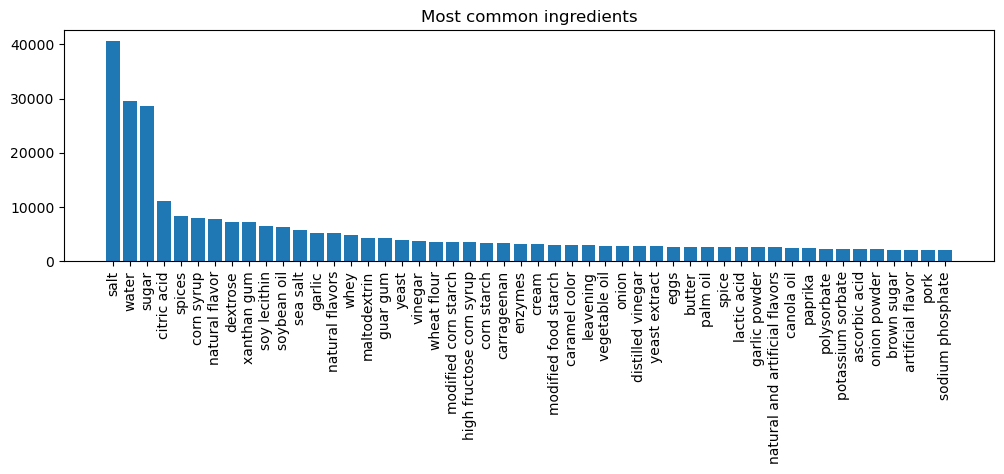

In [96]:
plt.figure(figsize=(12,3))
plt.title('Most common ingredients')
plt.bar(ingredients, counts_ingr)
g = plt.xticks(rotation=90)

The most used ingredient is the salt in almost 40000 receipts, followed by water and sugar with almost the same frequency of 30000.  
All the remaining ingredients are in about and less than 10000 receipts. 

# E) EDA: Time-series data

## 1. Investigate the total number of items created each month at each hour
Your task is to investigate the total number of items created each month at each hour. You should use the `created_at` column to draw a heatmap with the hours (0 to 23) on the **x**-axis and the months (1 to 12) on the **y**-axis. The color of the heatmap should show the number of items created at each month-hour pair. As always include any observations and their discussion.ion.

In [97]:
### Create a dataframe with hour, day, month and year columns extracted by created_at column
df_time = pd.DataFrame()
df_time['hour'] = pd.to_datetime(df_out.created_at).dt.hour
df_time['day'] = pd.to_datetime(df_out.created_at).dt.day
df_time['month'] = pd.to_datetime(df_out.created_at).dt.month
df_time['year'] = pd.to_datetime(df_out.created_at).dt.year
df_time = df_time.reset_index(drop=True)

In [98]:
### Create a heatmap dataframe for the frequency of hour and month
heatmap_data = df_time[['hour', 'month']].pivot_table(index='month', columns='hour', aggfunc=len, fill_value=0)

In [99]:
heatmap_data

hour    0   1   3   4   5    6    7    8   9      10   11   12  13  14   15  \
month                                                                         
1        0   0   0   0   0    2   11   33  51     30    3   20  23  17   12   
2        0   0   0   0   0    0    3   27  28     14    6   24  30  14    5   
3        0   0   0   0   0    0    9   34  35     38   40   43  41  44   62   
4        0   0   0   3  26   24   38   27  44  68821   28   39  25  26   10   
5        0   0   0   0   0    5   21   27  17     12   22   23  36  24    7   
6        0   0   0   0   0   84   24   40  49     11   20   43  47  92   54   
7      151  49   0   0   1  267   54   21  17    106   47   29  20  29   42   
8        1   0   1   0   0    5   22   27  27     12   26    7  20  12   14   
9        0   0   0   0  16  159   33   36  23     62  159  153  68  34  122   
10       0   0   0   0   0   15   14   30  18     13   39  105  13   5    8   
11       0   0   0   0   0    0  123  106  61     18   41   46  37  24    8   
12       0   0   0   0   0    1   11   15  26     24    4   13  59  18    4   

hour    16   17   18   19   20   21   22  23  
month                                         
1        3    3    1    2    2    0    1   0  
2        3    7    0    6    5   21    0   0  
3       10   22    2    3  156    0    0   0  
4        4    5    0   27    3   55    0   0  
5        0    8    2    7    0    0    0   0  
6       24   60   29    1    7   13   81   1  
7      204   73   83  112  331  133  144  82  
8       15   13   10   10    8    3    0   1  
9      457  348  282  461    3  177    0   0  
10       2    0   10    4   44    5    0   0  
11      19    5    2    9    4    1    3   0  
12       6    8    2    2   11    9    0   0

Text(0.5, 1.0, 'Heatmap of Hour vs Month')

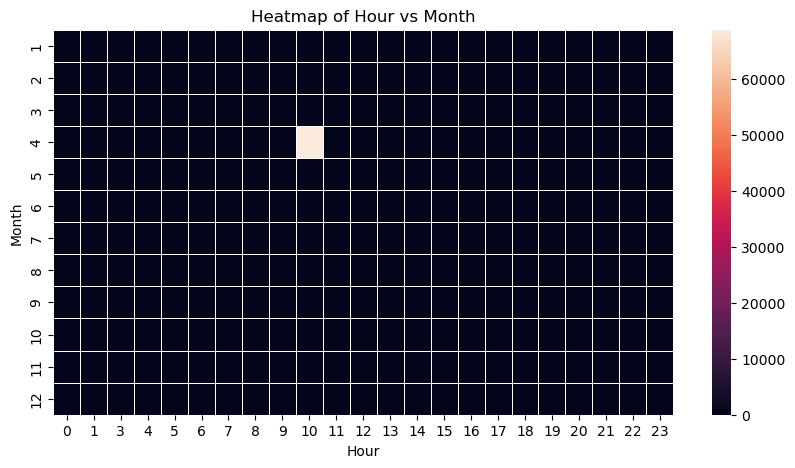

In [100]:
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data, linewidths=0.5)
plt.xlabel('Hour')
plt.ylabel('Month')
plt.title('Heatmap of Hour vs Month')

As shown in the previous heatmap, the majority of the events are in April at 10h.  
At this time there are so many events that it is not possible to visualize the others properly.  
For this reason, it is better to show them in logarithmic scale

Text(0.5, 1.0, 'Heatmap of Hour vs Month (Log-scaled)')

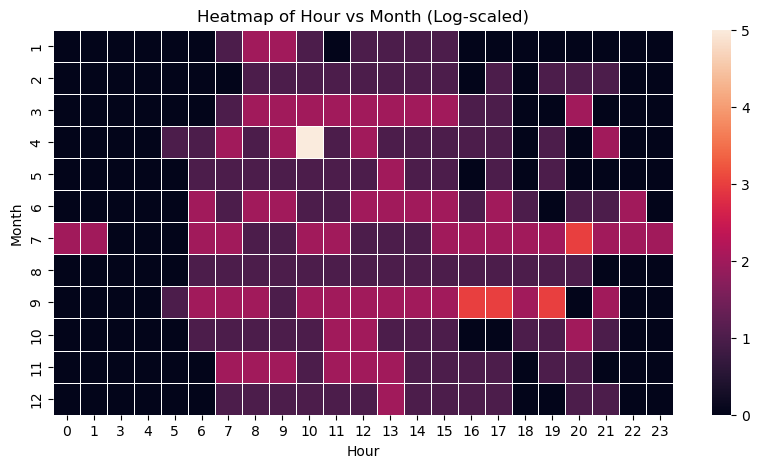

In [101]:
### Set the logarithmic scale not removing the zeros
heatmap_data_log = heatmap_data.apply(lambda x: x.apply(lambda y: 0 if y == 0 else round(np.log10(y))))

plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data_log, linewidths=0.5)

# Set labels and title
plt.xlabel('Hour')
plt.ylabel('Month')
plt.title('Heatmap of Hour vs Month (Log-scaled)')


Most of the events are between 6h to 21h, as usual working hours, for all month except for the summer months that have many events till the night.

## 2. Investigate the evolution of the total number of items over time
Your task is to investigate the evolution of the total number of items over time. You should draw a bar plot with the date (e.g., in yyyy-mm format) on the **x**-axis and the total number of items created during each **month** on the **y**-axis. Each bar in the plot should **stack** the number of items created by each country each month. Please make sure all bars are visible by choosing the appropriate scale for the **y**-axis. 

In [102]:
### Create a dataframe only with the columns created_at and country
df_stack = df_out[['created_at', 'country']].copy()
### Use only years and month
df_stack['created_at'] = pd.to_datetime(df_stack.created_at).dt.to_period('M')
df_stack.head()

C:\Users\enric\AppData\Local\Temp\ipykernel_219588\2714780612.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_stack['created_at'] = pd.to_datetime(df_stack.created_at).dt.to_period('M')


created_at country
3     2016-06      CH
4     2016-06      CH
6     2016-06      CH
8     2016-06      CH
10    2016-06      CH

In [103]:
### Count the number of items created by each country each month
df_pivot = pd.DataFrame(df_stack.value_counts()).unstack(level='country')
df_pivot.head()

count                    
country         CH  DE  FR  IT  UK  US
created_at                            
2016-05        8.0 NaN NaN NaN NaN NaN
2016-06      347.0 NaN NaN NaN NaN NaN
2016-07     1832.0 NaN NaN NaN NaN NaN
2016-08       13.0 NaN NaN NaN NaN NaN
2016-09     2330.0 NaN NaN NaN NaN NaN

Text(0.5, 1.0, 'Timeline of number of products created')

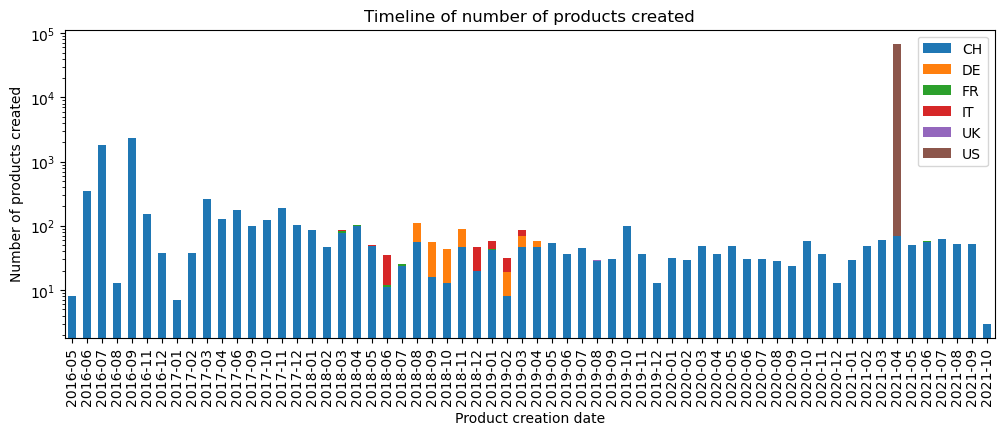

In [104]:
### Visualize the data
df_pivot.plot(kind='bar', stacked=True, figsize=(12, 4))
plt.yscale('log')
plt.legend(df_pivot.columns.levels[1])
# Adding labels and title
plt.xlabel('Product creation date')
plt.ylabel('Number of products created')
plt.title('Timeline of number of products created')

# F) EDA: Correlation analysis

## 1. Quantify the relationships
Your task is to quantify the **linear** relationships between the `energy_per_hundred` and the `per_hundred` columns by analysing their correlation with each other.

In [105]:
### Remove energy_per_hundred from the _per_hundred columns list
corr_columns_per_hundred = list(set(new_columns_per_hundred) - set(['energy_per_hundred']))
df_corr = df_out[new_columns_per_hundred].copy().corr()

<Axes: title={'center': 'Correlation matrix'}>

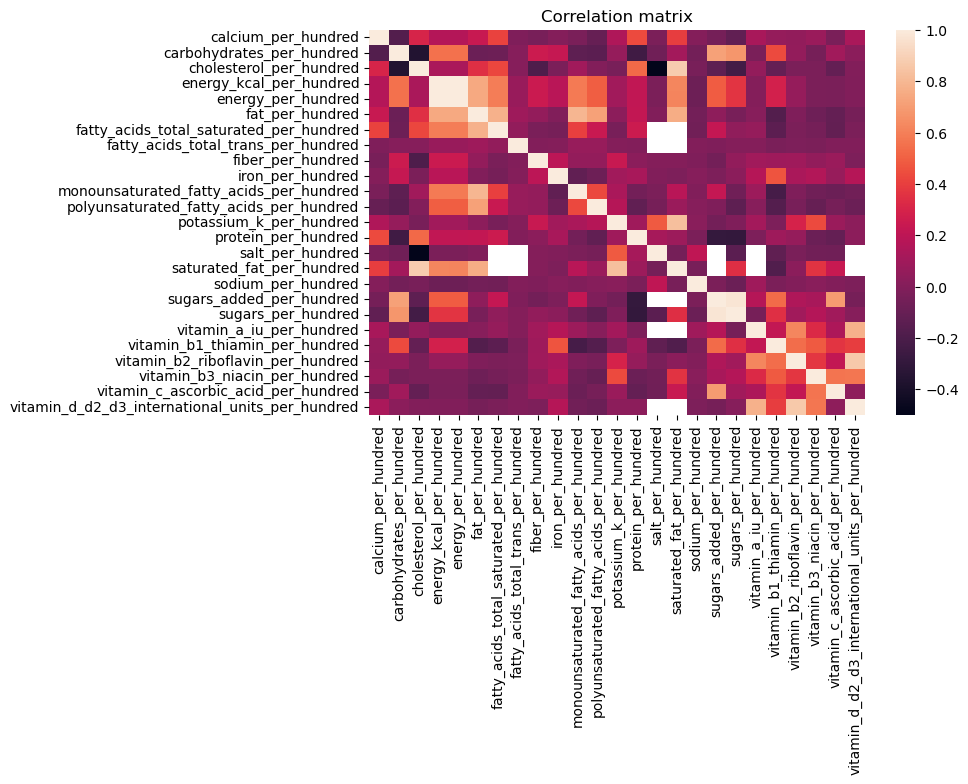

In [106]:
plt.figure(figsize=(8,5))
plt.title('Correlation matrix')
sns.heatmap(df_corr)

<Axes: title={'center': 'Correlation coefficients between energy_per_hundred and per_hundred columns'}, xlabel='energy_per_hundred'>

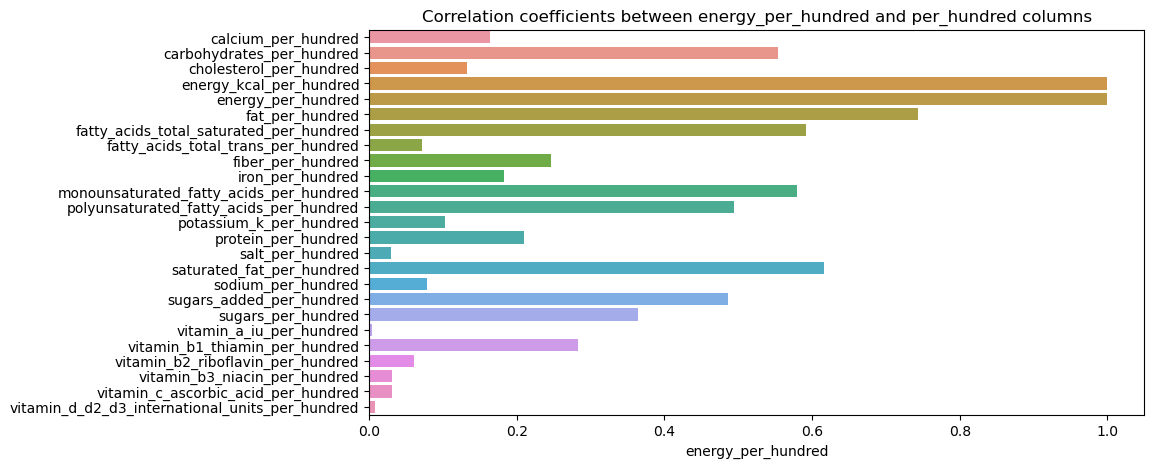

In [107]:
plt.figure(figsize=(10,5))
plt.title('Correlation coefficients between energy_per_hundred and per_hundred columns')
sns.barplot(x=df_corr.energy_per_hundred.abs(), y=df_corr.index)

## 2. Visualization of the relationships
Your task is to reveal the true nature of the relationship, **linear or non-linear**, between variables, using visualizations. Based on the correlation coefficients you found in the previous task, pick the three most correlated and the three least correlated nutrients (in absolute terms) with the `energy_per_hundred` column. Plot them against the `energy_per_hundred` column, using scatterplots. You should obtain these plots as subplots (with 2 rows and 3 columns) or as seaborn pairplots.
Please comment on the visual relationships in a markdown cell. Are they all linear? Are there still extreme values that, once removed, relationships would change?

In [108]:
# df_corr = df_corr.drop(index='energy_per_hundred')
sorted_corr = df_corr.drop(index='energy_per_hundred').energy_per_hundred.abs().sort_values(ascending=False)
most_corr_nutrients = sorted_corr[:3]
least_corr_nutrients = sorted_corr[-3:]

print(f'The most correlated nutrients with energy_per_hundred are: {most_corr_nutrients.index.values}')
print(f'The least correlated nutrients with energy_per_hundred are: {least_corr_nutrients.index.values}')

The most correlated nutrients with energy_per_hundred are: ['energy_kcal_per_hundred' 'fat_per_hundred' 'saturated_fat_per_hundred']
The least correlated nutrients with energy_per_hundred are: ['salt_per_hundred' 'vitamin_d_d2_d3_international_units_per_hundred'
 'vitamin_a_iu_per_hundred']


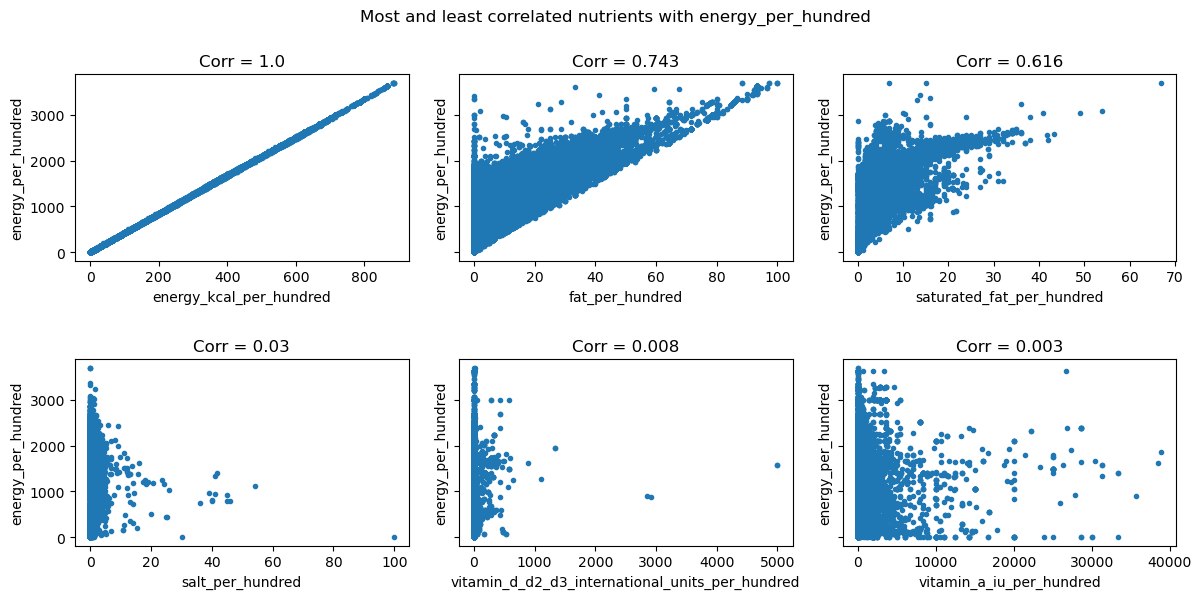

In [109]:
fig, (ax1, ax2) = plt.subplots(2, 3, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(12)
fig.suptitle('Most and least correlated nutrients with energy_per_hundred')
fig.tight_layout(h_pad=5, pad=2)

for i in range(3):
    ax1[i].plot(df_out[most_corr_nutrients.index.values[i]], df_out.energy_per_hundred, '.')
    ax1[i].set_title(f'Corr = {round(most_corr_nutrients.iloc[i], 3)}')
    ax1[i].set_ylabel('energy_per_hundred')
    ax1[i].set_xlabel(most_corr_nutrients.index.values[i])

for i in range(3):
    ax2[i].plot(df_out[least_corr_nutrients.index.values[i]], df_out.energy_per_hundred, '.')
    ax2[i].set_title(f'Corr = {round(least_corr_nutrients.iloc[i], 3)}')
    ax2[i].set_ylabel('energy_per_hundred')
    ax2[i].set_xlabel(least_corr_nutrients.index.values[i])

The `energy_per_hundred` and `energy_kcal_per_hundred` are fully linear because they represent the same quantity expressed in kJ and kCal respectively.  
The columns `fat_per_hundred` and `saturated_fat_per_hundred` have almost the same corelation coefficient with `energy_per_hundred`, but are not fully linear.    
As shown in the last 3 plots, `salt_per_hundred`, `vitamin_d_d2_d3_international_units_per_hundred` and `vitamin_a_iu_per_hundred` are not correlated with `energy_per_hundred`.  
There are only a few outliers and removing them will not increase the relationships. 

## 3. Test the independence
Your task is to test the independence of two **categorical variables statistically**. Use the `energy_per_hundred` column to create a new variable that holds equal proportion of values in three categories _low energy_, _medium energy_ and _high energy_. Test if the level of energy in the product is associated with the country where the product is produced.

In [110]:
df_out.energy_per_hundred.describe()

count    76909.000000
mean      1104.880055
std        713.926436
min          0.000000
25%        447.690000
50%       1100.390000
75%       1644.310000
max       3700.000000
Name: energy_per_hundred, dtype: float64

In [111]:
### Create categories with equal proportions based on the actual range of values in the energy_per_hundred column
bin_edges = pd.cut(df_out['energy_per_hundred'], bins=3, retbins=True, labels=False)[1]

# Create categories based on calculated bin edges
df_out.loc[:, 'energy_level'] = pd.cut(df_out['energy_per_hundred'], 
                                       bins=bin_edges, 
                                       labels=['low energy', 'medium energy', 'high energy'], 
                                       include_lowest=True)

To test the independency of the variables let's use the $\chi^2$ test of independency using **scipy.stats.chi2_contingency**.  
Let's make the hypotesis and choose the p-value:  
- $H_0$ - (p-value > 0.05): the 2 variables are independent from each other (no correlation)
- $H_1$ - (p-value < 0.05): the 2 variables are dependent from each other (correlation)

In [112]:
### Count the number of items created by each country each month
df_energy = pd.DataFrame(df_out[['energy_level', 'country']].value_counts()).unstack(level='country')
df_energy.head()

count                                
country            CH     DE   FR    IT   UK       US
energy_level                                         
low energy     4003.0   83.0  3.0  34.0  1.0  38786.0
medium energy  3554.0  110.0  9.0  63.0  NaN  28594.0
high energy     216.0   19.0  NaN   1.0  NaN   1433.0

In the dataframe there are missing that cannot be used to compute the $\chi^2$.  
These missing values are caused by poor statistics for France and UK

In [113]:
df_out.country.value_counts()

country
US    68813
CH     7773
DE      212
IT       98
FR       12
UK        1
Name: count, dtype: int64

Let's remove these two columns and compute the $\chi^2$ test of independence

In [114]:
stats.chi2_contingency(df_energy['count'].drop(columns=['FR', 'UK']))

Chi2ContingencyResult(statistic=154.80386918111654, pvalue=7.4552314123960435e-31, dof=6, expected_freq=array([[4.33713507e+03, 1.18290574e+02, 5.46814919e+01, 3.83958929e+04],
       [3.26715477e+03, 8.91080420e+01, 4.11914534e+01, 2.89235457e+04],
       [1.68710167e+02, 4.60138369e+00, 2.12705472e+00, 1.49356139e+03]]))

The results of the statistics are:
- $\chi^2$ = 154.8
- p-value = $7 \cdot 10^{-31}$
- dof = 6

Since the p-value is much lower than 0.05, we can reject the null hypotesis and consider the variables dependent from each other.

# G) Advanced EDA

## 1. Samples by country  
What is the total number of samples by country? Countries with very small sample size should be dropped from this analysis as their results may not be statistically significant.

In [115]:
df_out.country.value_counts()

country
US    68813
CH     7773
DE      212
IT       98
FR       12
UK        1
Name: count, dtype: int64

In [116]:
### Let's remove UK
countries_to_remove = ['FR', 'UK']
df_out = df_out[~df_out.country.isin(countries_to_remove)]
df_out.country.value_counts()

country
US    68813
CH     7773
DE      212
IT       98
Name: count, dtype: int64

## 2. Organic and bio products  
Count the number of organic and non-organic products in each country. Is there a country with a higher percentage of organic products?

In [117]:
### Convert product_name in lower case
df_out.product_name = df_out.product_name.str.lower()
### Select the indices of the products that contain 'bio' or 'organic' in the product_name
organic_index = df_out[df_out.product_name.str.contains('bio|organic') == True].index
### Create a NaN product_type column 
df_out['product_type'] = np.nan
df_out['product_type'] = df_out['product_type'].astype('object')
### Fill the product_type column with 'bio', 'organic' and 'not_specified'
df_out.loc[organic_index, 'product_type'] = 'organic'
df_out.product_type = df_out.product_type.fillna('not_organic')

In [118]:
### Print the number of organic and non-organic product
df_out.product_type.value_counts()

product_type
not_organic    73345
organic         3551
Name: count, dtype: int64

In [119]:
### Print the percentage of organic and non-organic product in each country
df_out.groupby('country').product_type.value_counts(normalize=True)

country  product_type
CH       not_organic     0.934002
         organic         0.065998
DE       not_organic     0.853774
         organic         0.146226
IT       not_organic     0.979592
         organic         0.020408
US       not_organic     0.956331
         organic         0.043669
Name: proportion, dtype: float64

The most products in each country are non-organic.  
The country with the most percentage of organic products is Germany with 14.6% of the total product type

## 3. Distribution of macronutrients
Totals or portions don’t give a very detailed picture. Compare the **distributions** of the macronutrients between organic and non-organic products in each country. Your solution method should include appropriate visualisations in the subplots format. Note that bar charts are not the best way to communicate distributions.

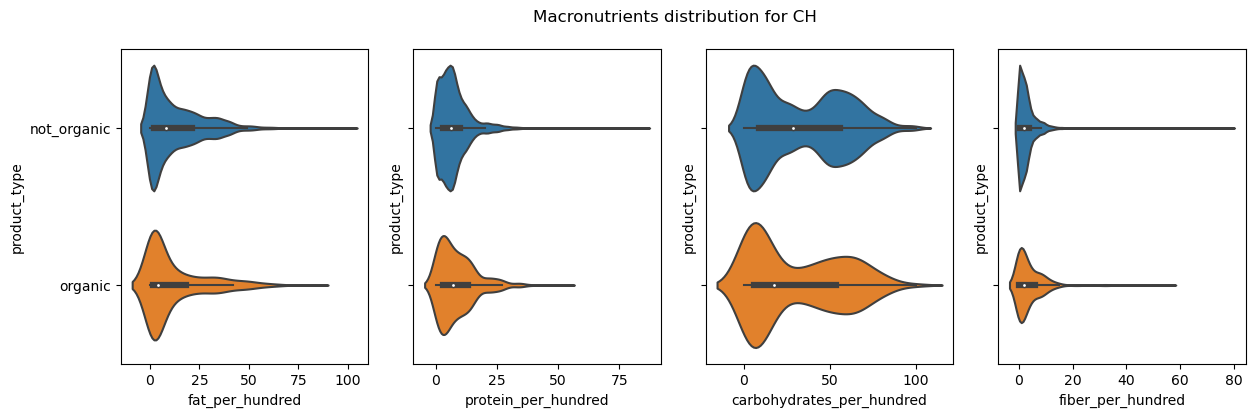

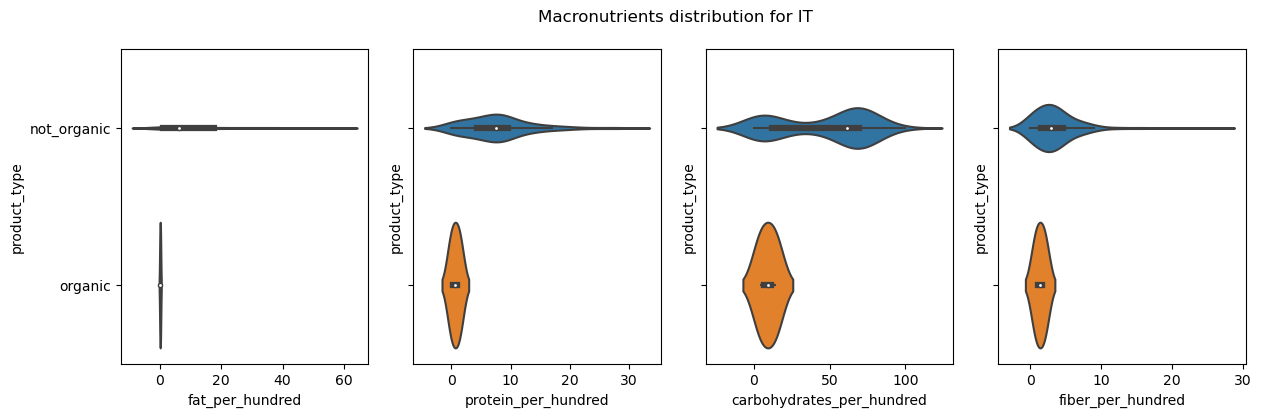

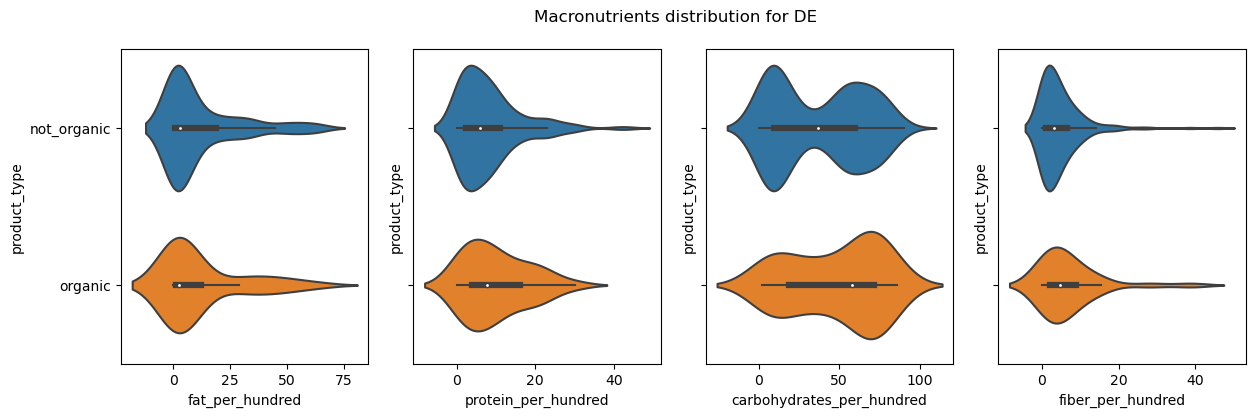

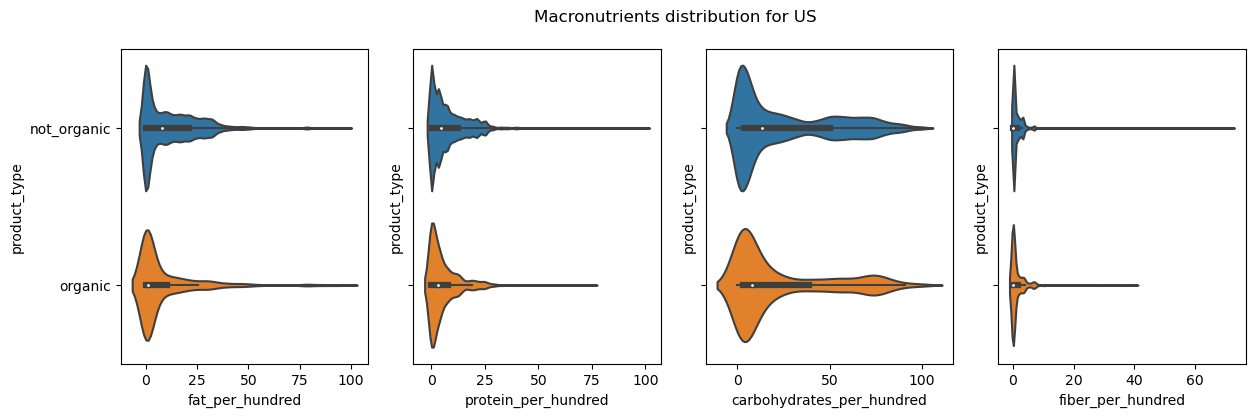

In [120]:
### Visualize the distribution of the macronutrients  between organic and non-organic products in each country using violinplot
for c in df_out.country.unique():
    fig, axs = plt.subplots(1, 4, figsize=(12, 4), sharey=True)
    fig.suptitle(f'Macronutrients distribution for {c}')
    fig.tight_layout(h_pad=2, pad=1)
    sns.violinplot(data=df_out[df_out.country == c], x=bulk[0], y='product_type', ax=axs[0])
    sns.violinplot(data=df_out[df_out.country == c], x=bulk[1], y='product_type', ax=axs[1])
    sns.violinplot(data=df_out[df_out.country == c], x=bulk[2], y='product_type', ax=axs[2])
    sns.violinplot(data=df_out[df_out.country == c], x=bulk[3], y='product_type', ax=axs[3])